In [2]:
rm(list=ls())

1.数据预处理========================================

In [ ]:
#预处理工作
#1.对数据进行重采样，都统一为0.5*0.5的分辨率
#2.进行数据清洗
#3.将数据生成连续的时间序列，并生成36个子文件

1.1 处理ERA5-land在分析1°合成PET数据集


In [54]:
#下载链接https://data.bris.ac.uk/data/dataset/qb8ujazzda0s2aykkv0oq0ctp
#lat=-90~90  lon=-180~180
#0.1°
#unit mm/day
library(ncdf4)
library(abind)
library('dplyr')
#library('tibbletime')
library(stringr)
library(raster)


In [ ]:
#重采样和数据清洗（在服务器处理）
library(ncdf4)
library(abind)
library('dplyr')
#library('tibbletime')
library(stringr)
library(raster)

ffname="E:\\NO.1 flash drought\\03data\\ERA5\\ERA5_LAND_PET\\data\\"
#pet_filename=paste0(ffname,"1990_daily_pet.nc")
#ffname="/scratch/xtan/dsm_3/ERA5_Land/PET/data/"
fname=list.files(ffname)
pet_filename=paste0(ffname,fname)

sample<- raster(xmn=-180, xmx=180, ymn=-90, ymx=90, 
                resolution=0.5, vals=NULL)           #构建样本
for(j in 1:length(pet_filename)){
pet_raster <- brick(pet_filename[j],varname="pet") #提取多层的raster
#dim(pet_raster)

pet_slip=subset(pet_raster, 1)
pet_slip[pet_slip>1000]=NA  #数据清洗
pet_clean_inter <- resample(pet_slip,sample, method='bilinear')   #进行重采样
for(i in 2:dim(pet_raster)[3]){
pet_slip=subset(pet_raster, i)
pet_slip[pet_slip>1000]=NA  #数据清洗
re_data <- resample(pet_slip,sample, method='bilinear')   #进行重采样
pet_clean_inter=stack(pet_clean_inter,re_data)
print(i)
}
save(pet_clean_inter,file=paste0(ffname,"pet_clean_inter","_",(1979+i),".RData"))  #ps:显示的年份比实际年份小一年
}
#将服务器数据下载到本地


In [ ]:
#将所有年份的数据合并起来
#PET  分成36个文件
library(raster)
library(abind)
#file_name=list.files("/scratch/xtan/dsm_3/ERA5_Land/PET")
file_name=list.files("E:\\NO.1 flash drought\\03data\\ERA5")
file_name_1 <- grep("pet_clean_inter_",file_name,value=T)
file_name_2= paste0("E:\\NO.1 flash drought\\03data\\ERA5\\",file_name_1)
for(i in 1:36){
load(file_name_2[1])
pet_clean_inter_1=pet_clean_inter[((i-1)*10+1):(10*i),,]
for(x in 2:length(file_name_2)){
load(file_name_2[x])
#pet_clean_inter_1=stack(pet_clean_inter_1,pet_clean_inter[((i-1)*10+1):(10*i),,])
pet_clean_inter_1=abind(pet_clean_inter_1,pet_clean_inter[((i-1)*10+1):(10*i),,])
 print(x)
 }
 save(pet_clean_inter_1,file=paste0("E:\\NO.1 flash drought\\03data\\ERA5\\pet_clean_data_",i,".RData"))
 }


1.2处理ERA5LAND-ET数据

In [ ]:
#下载代码
#source("E:\NO.1 flash drought\03data\ERA5\下载代码\ERA5_download_E.py")
#lat=-90~90  lon=0-360
#0.5°
#unit mm/day
library(ncdf4)
library(abind)
library('dplyr')
#library('tibbletime')
library(stringr)
library(raster)

In [ ]:
#读取文件列表（服务器）
YEAR=1991
ffname=paste0("/scratch/xtan/dsm_3/ERA5_Land/E/",YEAR)
eta_filename = NULL
file_name<-list.files(ffname)
setwd(ffname)
#file_name_1 <- grep(paste0("era5.evaporation.",YEAR),file_name,value=T)
#file_name_1 <- paste0(ffname,file_name_1)
#file_name_1 <- paste0("E:\\NO.1 flash drought\\03data\\ERA5\\ERA5-LAND\\",file_name_1)
#file_name_1

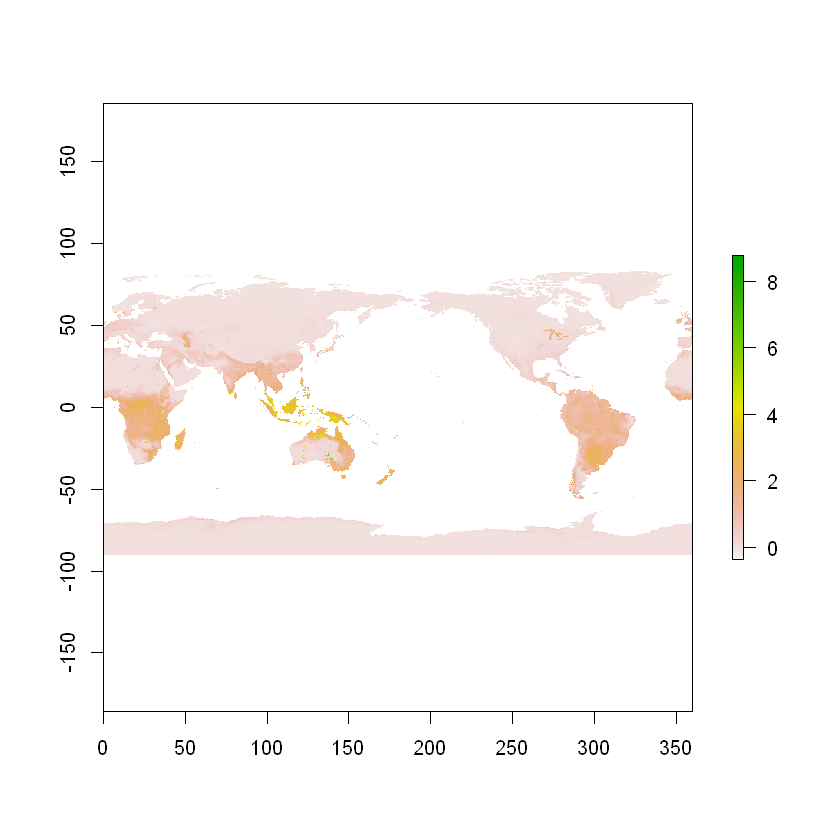

In [ ]:
##处理实际蒸散发
#测试
fun<-function(x){
dat<-mean(x)*(-1000)
return(dat)
}
et_file <- brick(file_name[5],varname="e")  #注意要选择变量
et_daily_file <- calc(et_file,fun)  

plot(et_daily_file)


In [52]:
#对ET进行数据清洗并且合并数据（一年一个文件）（服务器处理）
ET_FUN=function(YEAR){
#批处理(数据清洗)
fun<-function(x){
dat<-mean(x)*(-1000)  #单位转换
return(dat)
}

file=1
et_file <- brick(file_name[file],varname="e")  #注意要选择变量
et_daily_data <- calc(et_file,fun)  
#et_daily_data = NULL
for(file in 2:length(file_name)){#
et_file <- brick(file_name[file],varname="e")  #注意要选择变量
et_daily_file <- calc(et_file,fun)               #计算日蒸发量
et_daily_data <- stack(et_daily_data,et_daily_file)
print(file)
}

#转换经度（0~360，-180~180）
class(et_daily_data)
x1=crop(et_daily_data,extent(-0.25,179.75,-90.25,90.25))
x2=crop(et_daily_data,extent(179.75,359.75,-90.25,90.25))
extent(x2)=c(-180.25,-0.25,-90.25,90.25)
et_inter_data=merge(x2,x1)#
#plot(et_inter_data)

#save(et_inter_data,file=paste0("E:\\NO.1 flash drought\\03data\\ERA5\\et_inter_0.5_",YEAR,".RData"))
print(YEAR)
return(et_inter_data)
}

sapply(1980:2020,ET_FUN)


[1] 2
[1] 3
[1] 1991


In [ ]:
#Linux合成et_clean_inter代码（分成36个文件的1981-2020年的数据文件）（服务器）
library(raster)
library(abind)
file_name=list.files("/scratch/xtan/dsm_3/ERA5_Land/E")
file_name_1 <- grep("et_inter_0.5_.",file_name,value=T)
file_name_2= paste0("/scratch/xtan/dsm_3/ERA5_Land/E/",file_name_1)

for(i in 1:36){
  load(file_name_2[1])
  et_clean_inter_1=et_inter_data[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    et_clean_inter_1=abind(et_clean_inter_1,et_inter_data[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(et_clean_inter_1,file=paste0("/scratch/xtan/dsm_3/ERA5_Land/E/data/et_clean_data_",i,".RData"))
}
#下载到本地

1.3处理GLEAM-0.5-ET/PET/SM数据

In [ ]:
#工作站处理
library(ncdf4)
library(abind)
library('dplyr')
#library('tibbletime')
library(stringr)
library(raster)

sample<- raster(xmn=-180, xmx=180, ymn=-90, ymx=90, 
                resolution=0.5, vals=NULL)  
#1)对GLEAM数据进行重采样，改为0.5*0.5
year=1980
input_path <- "/media/xtan/15777115545/1.data_file/09 GLEAM/daily/"
out_path <-"/media/xtan/15777115545/temporary/data/gleam0.5/"

for(year in 1981:2020){
 pet_filename=paste0(input_path,year,"/","Ep_",year,"_GLEAM_v3.5a.nc")
 pet_raster <- brick(pet_filename,varname="Ep") #提取多层的raster
 pet_resample <- resample(pet_raster,sample, method='bilinear')   #进行重采样
 save(pet_resample,file=paste0(out_path,"pet/pet_resample_gleam0.5_",year,".RData"))
# 
 et_filename=paste0(input_path,year,"/","E_",year,"_GLEAM_v3.5a.nc")
 et_raster <- brick(et_filename,varname="E") #提取多层的raster
 et_resample <- resample(et_raster,sample, method='bilinear')   
 save(et_resample,file=paste0(out_path,"eta/et_resample_gleam0.5_",year,".RData"))

 sm_filename=paste0(input_path,year,"/","SMsurf_",year,"_GLEAM_v3.5a.nc")
 sm_raster <- brick(sm_filename,varname="SMsurf") #提取多层的raster
 sm_resample <- resample(sm_raster,sample, method='bilinear') 
save(sm_resample,file=paste0(out_path,"sm/sm_resample_gleam0.5_",year,".RData"))
print(year)
}

#2)合并为连续的时间序列
library(raster)
library(abind)

input_path <- "/media/xtan/15777115545/temporary/data/gleam0.5/"
out_path <-"/media/xtan/15777115545/temporary/data/gleam0.5/"

var="pet"
var1="pet1/"

file_name_2=list.files(paste0(input_path,var)) 
#file_name_2= paste0(input_path,file_name_1)
setwd(paste0(input_path,var))
for(i in 1:36){
  load(file_name_2[1])
  pet_resample_1=pet_resample[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    #pet_clean_inter_1=stack(pet_clean_inter_1,pet_clean_inter[((i-1)*10+1):(10*i),,])
    pet_resample_1=abind(pet_resample_1,pet_resample[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(pet_resample_1,file=paste0(out_path,var1,var,"_resample_",i,".RData"))
}


var="eta"
var1="eta1/"

file_name_2=list.files(paste0(input_path,var)) 
#file_name_2= paste0(input_path,file_name_1)
setwd(paste0(input_path,var))
for(i in 1:36){
  load(file_name_2[1])
  et_resample_1=et_resample[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    #pet_clean_inter_1=stack(pet_clean_inter_1,pet_clean_inter[((i-1)*10+1):(10*i),,])
    et_resample_1=abind(et_resample_1,et_resample[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(et_resample_1,file=paste0(out_path,var1,var,"_resample_",i,".RData"))
}


var="sm"
var1="sm1/"

file_name_2=list.files(paste0(input_path,var)) 
#file_name_2= paste0(input_path,file_name_1)
setwd(paste0(input_path,var))
for(i in 1:36){
  load(file_name_2[1])
  sm_resample_1=sm_resample[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    #pet_clean_inter_1=stack(pet_clean_inter_1,pet_clean_inter[((i-1)*10+1):(10*i),,])
    sm_resample_1=abind(sm_resample_1,sm_resample[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(sm_resample_1,file=paste0(out_path,var1,var,"_resample_",i,".RData"))
}


1.4处理ERA5-ET数据

In [ ]:
library(ncdf4)
library(raster)

sample<- raster(xmn=0, xmx=360, ymn=-90, ymx=90, 
                 resolution=0.5, vals=NULL)  
fun<-function(x){
    dat<-mean(x)*(-10000)
    return(dat)
  }
#蒸发数据批处理
#服务器
#YEAR=1991


#对ET进行数据清洗并且合并数据（一年一个文件）（服务器处理）
ET_FUN=function(YEAR){
   ffname=paste0("/scratch/xtan/dsm_3/ERA5/E/",YEAR)
   setwd(ffname)
   file_name<-list.files(ffname)
  #批处理(数据清洗)
  file=1
  et_file <- brick(file_name[file],varname="e")  #注意要选择变量
  et_daily_data <- calc(et_file,fun)  
  #et_daily_data = NULL
  for(file in 2:length(file_name)){#
    et_file <- brick(file_name[file],varname="e")  #注意要选择变量
    et_daily_file <- calc(et_file,fun)               #计算日蒸发量
    et_daily_data <- stack(et_daily_data,et_daily_file)
    print(file)
  }
  
  et_inter <- resample(et_daily_data,sample, method='bilinear')   #进行重采样，一年
  #save(et_inter,file="E:\\NO.1 flash drought\\03data\\ERA5\\et_inter.RData")
  
  #转换坐标
  class(et_inter)
  x1=crop(et_inter,extent(0,180,-90,90))
  x2=crop(et_inter,extent(180,360,-90,90))
  extent(x2)=c(-180,0,-90,90)
  et_inter_data=merge(x2,x1)#
  #plot(et_inter_data)
  
  save(et_inter_data,file=paste0("/scratch/xtan/dsm_3/ERA5/E/ERA5-ET/ET1/et_inter_0.5_",YEAR,".RData"))
  print(YEAR)
  return(YEAR)
}

sapply(1981:1990,ET_FUN)



In [ ]:
#Linux合成et_clean_inter代码（分成36个文件的1981-2020年的数据文件）（服务器）
library(raster)
library(abind)
file_name_2=list.files("/scratch/xtan/dsm_3/ERA5/E/ERA5-ET/ET1/")
# file_name_1 <- grep("et_inter_0.5_.",file_name,value=T)
# file_name_2= paste0("/scratch/xtan/dsm_3/ERA5_Land/E/",file_name_1)
setwd("/scratch/xtan/dsm_3/ERA5/E/ERA5-ET/ET1")
for(i in 1:36){
  load(file_name_2[1])
  et_clean_inter_1=et_inter_data[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    et_clean_inter_1=abind(et_clean_inter_1,et_inter_data[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(et_clean_inter_1,file=paste0("/scratch/xtan/dsm_3/ERA5/E/ERA5-ET/ET2/et_clean_data_",i,".RData"))
}


2.计算骤旱=====================================

2.3 GLEAM-0.5识别骤旱

In [ ]:
fname="/media/xtan/15777115545/temporary/2.R_copyTX/function"
source(paste0(fname,"/Alencar2021.R"))
source(paste0(fname,"/Christian2020_clean_data2.R"))
source(paste0(fname,"/Christian20202.R"))
source(paste0(fname,"/FordLabosier2017.R"))
source(paste0(fname,"/Mo2016.R"))
source(paste0(fname,"/Noguera2020.R"))
source(paste0(fname,"/Osman2021.R"))
source(paste0(fname,"/conf_mat.R"))
source(paste0(fname,"/de_tha_d.R"))
source(paste0(fname,"/de_tha_h.R"))
source(paste0(fname,"/df_fluxnet.R"))
source(paste0(fname,"/eddi_anomaly.R"))
source(paste0(fname,"/eddi_percentile.R"))
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fspei.R"))
source(paste0(fname,"/fweek.R"))
source(paste0(fname,"/fyear.R"))
source(paste0(fname,"/get_df_era5.R"))
source(paste0(fname,"/getncdata.R"))
source(paste0(fname,"/hargreaves_day.R"))
source(paste0(fname,"/multicriteria_fd.R"))
source(paste0(fname,"/param_loglogist.R"))
source(paste0(fname,"/penman_day.R"))
source(paste0(fname,"/preparenc.R"))
source(paste0(fname,"/process_all.R"))
source(paste0(fname,"/Pendergrass2020.R"))

#library('tidyr')
library('dplyr')
library('tibbletime')
library(ncdf4)
library(abind)
library(pracma)
year = 1981:2020
#lat1 = seq(89.5, -90, -0.5 )
# lon1 = seq(179.5,-180, -0.5 )
pentad_idx_in_growing_season_nh = c(16:60)
pentad_idx_in_growing_season_sh = c(1:20, 46:73)
#nlon = 20
# nlon = 5
# nlat=10
# lat = rep(lat1,nlon)
# lat = matrix(lat, nrow = length(lat1))
# lat = as.vector(t(lat))
i_batch=1

for(i_batch in 1:36){
  load(paste0("/media/xtan/15777115545/temporary/data/gleam0.5/eta1/eta_resample_",i_batch,".RData"))
  load(paste0("/media/xtan/15777115545/temporary/data/gleam0.5/pet1/pet_resample_",i_batch,".RData"))
  
  #i_batch=19
  # load("E:/NO.1 flash drought/04code/LINUX/et_clean_data_19.RData")
  # load("E:/NO.1 flash drought/04code/LINUX/pet_clean_data_19.RData")
  
  eta=et_resample_1
  pet=pet_resample_1
  
  #for (i_batch in 90:119){
  
  # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\pet\\","pet_",i_batch,".RData"))
  # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\eta\\","eta_",i_batch,".RData"))
  
  m = dim(eta)
  time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
  
  ### transform daily data to pentad data and the standardized differential time series
  
  #pentad.esr = pentad.sesr = pentad.delta_sesr = array(NA, dim = c(m[1:2], length(year) * 73 ))
  pentad.esr = pentad.sesr = pentad.delta_sesr = matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
  #j=432
  #k=3
  
  for(j in 1:m[1]){
    #for (k in 1:m[2]) {
    pet1 =  pet[j,] 
    pet1[pet1<0] = NA
    eta1 = eta[j,]
    eta1[eta1<0] = NA
    if ( length(pet1[is.na(pet1)]) < 0.1 * m[2] &  length(eta1[is.na(eta1)]) < 0.1 * m[2] &  mean(pet1-eta1, na.rm = T) !=0   ) {
      if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
        dat = Christian2020_clean_data (vtime=time, vET0=pet1, vETa=eta1, threshold = 1)
        #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
        dat_series = as.vector(dat$pentad_matrix)
        if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
          pentad.esr[j, ] = dat_series
          pentad.sesr[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
          pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
          print("Pass the data clean!")
        }
      }
    }
  }
  
  
  ###################################################################################################
  ################################# flash drought identification ####################################
  ###################################################################################################
  
  # reshape sesr and standardized_sesr_change into 3 dimensions (space *  pentads, years )
  pentad_in_year = 73
  sesr_3d = standardized_sesr_change_3d = array(NA, dim = c(m[1] , pentad_in_year, length(year) ))  #构建三维数组
  
  for(i_lat in 1:m[1]){
    #for(i_lon in 1:m[2]){
    sesr_3d[i_lat,,] = matrix(pentad.esr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
    standardized_sesr_change_3d[i_lat,,] = matrix(pentad.delta_sesr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
    # }
  }
  
  # detrend sesr and standardized_sesr_change
  sesr = standardized_sesr_change = matrix(NA, dim(sesr_3d)[1],dim(sesr_3d)[2]*dim(sesr_3d)[3])
  for(g in 1:dim(sesr_3d)[1]){
    ddd = as.vector (sesr_3d[g,,])
    if(length(ddd[!is.na(ddd)]) > 0.8*length(ddd)  ){
      sesr_3d[g,,]  =  t(apply(sesr_3d[g,,], 1, detrend)) #1是按行计算
      # reshape detrended data into 2 dimensions (space *  time)
      sesr[g,] = as.vector(sesr_3d[g,,])
      standardized_sesr_change_3d[g,,]  =  t( apply(standardized_sesr_change_3d[g,,], 1, detrend)) 
      # reshape detrended data into 2 dimensions (space *  time)
      standardized_sesr_change[g,] = as.vector(standardized_sesr_change_3d[g,,])
    }
  }
  
  # Find percentiles from sesr and standardized_sesr_change
  sesr_drought_prctile = 20 *0.01
  sesr_change_prctile  = 40 *0.01 
  drought_sesr = apply (sesr_3d, FUN= quantile, probs = sesr_drought_prctile, na.rm=T, MARGIN=c(1,2))                            #低于20%的SESR
  min_sesr_change = apply (standardized_sesr_change_3d, FUN=  quantile, probs = sesr_change_prctile, na.rm=T, MARGIN=c(1,2)  )   #低于40%的delta SESR
  # rm(sesr_3d, sesr_drought_prctile, sesr_change_prctile) 
  
  # Create flash drought directory to store information of flash droughts
  flash_drought_directory = rep (list(list('fd_start'= NULL,
                                           'fd_end' = NULL,
                                           'mean_sesr_change' = NULL,
                                           'fd_length' = NULL ,
                                           'fd_intensity' = NULL,
                                           'pre_sesr' = NULL,
                                           'non_moderated_fd' = NULL )), dim(sesr)[1] )
  
  # Find flash drought events
  print('Starting find flash drought events')
  
  count = 0
  n_ind = 1
  total_grids = dim(sesr)[1]
  n_pentads = dim(sesr)[2]
  
  # Loop through each spatial point
  #i=7145
  for (i in 1:dim(sesr)[1]) {
    if( length(min_sesr_change[i,][is.na(min_sesr_change[i,])]) < 1 ){  # make sure the time series is able to be identified
      #     print(i)
      #   }
      # }
      new_flash = 0             #是否是第一次出现骤旱，0=是
      continuous_flash = 0      #骤旱是否持续时间
      was_flash = 0             #之前是否发生骤旱
      was_interrupted = 0       #是否有间段
      flash_interruption = 0    #骤旱间段次数
      length_flash_drought = 0  #骤旱持续时间
      
      ## Loop through all pentads
      
      for ( n in 2:(n_pentads - 1) ){   #由于delta SESR的错位，所以从第二个pentad开始，(n_pentads - 1)
        if(!is.na(standardized_sesr_change[i,n]) & !is.na(sesr[i,n + 1])){
          n_y = mod(n,73)  #n_y判断属于第几个pentad
          if (n_y == 0){
            n_y = 73
          }
          if ( (new_flash != 1) & (continuous_flash != 1) ){
            if ( (standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ) ){
              #if ( drought_m[n]==1 ){
              new_flash = 1
              length_flash_drought = length_flash_drought + 1
            }
            #print(paste0(n,"of if 1"))
          }else if ( (new_flash == 1) & (continuous_flash != 1) ){
            if  ( standardized_sesr_change[ i, n] < min_sesr_change[i, n_y] ){
              #if ( drought_m[n]==1 ){
              continuous_flash = 1
              new_flash = 0
              flash_interruption = 0
              if (length_flash_drought == 0 ){
                length_flash_drought = length_flash_drought_new + 1  #length_flash_drought_new?
              }else{
                length_flash_drought = length_flash_drought + 1
              }
            }else if( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if( drought_m[n]==0 ){
              if ( flash_interruption == 0 ) {
                continuous_flash = 1
                new_flash = 0
                flash_interruption = 1
              }else if(flash_interruption == 1){
                # The following elseif statement is likely never reached -
                # consider deleting after running tests
                new_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              new_flash = 0
              continuous_flash = 1
            }
            #print(paste0(n,"of if 2"))
          }else if( (new_flash != 1) & (continuous_flash == 1) ){
            if ( standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ){
              #if (drought_m[n]==1){
              if(flash_interruption == 1){
                if( sesr[i,n + 1] < sesr[i,n - 1] ){
                  if (length_flash_drought == 0){
                    length_flash_drought = length_flash_drought_new + 2
                  }else{
                    length_flash_drought = length_flash_drought + 2
                  }
                  flash_interruption = 0
                  was_interrupted = 1
                }else{
                  continuous_flash = 0
                  was_flash = 1
                  #print(paste0("occurrence flash_",n))
                  flash_interruption = 0
                  new_flash = 1
                  length_flash_drought_new = 1
                }
              }else if(flash_interruption == 0){
                length_flash_drought = length_flash_drought + 1
              }
            }else if ( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if ( drought_m[n]==0){  
              if (flash_interruption == 0){
                flash_interruption = 1
              }else if(flash_interruption == 1){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              if (is.nan(sesr[i,n])){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }else{
                continuous_flash = 1
                flash_interruption = 1
              }
            }
            #print(paste0(n,"of if 3"))
          }
          if (was_flash == 1){
            # Check if flash drought is in growing season
            length_flash_drought_adj = length_flash_drought + 1  
            fd_n_begin = n - (length_flash_drought_adj)         #不理解？？
            fd_n_end = n - 1
            #if (lat[i] > 30){  # ok<DTSET>
            if (i_batch<=3){
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_nh) | (mod (fd_n_begin, 73) %in% pentad_idx_in_growing_season_nh) ) {
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] < -30){
            else if (i_batch>=34){ 
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_sh) | ( mod(fd_n_begin,73) %in% pentad_idx_in_growing_season_sh) ){
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] <= 30 & lat[i] >= -30){
            else if (i_batch<34 & i_batch>3){  
              in_grow_seas = 1
            }
            
            # Check if flash drought ended in drought and is minimum length
            
            if( n_y == 1){
              n_y = 74
            } 
            if ((sesr[i,n - 1] < drought_sesr[i,n_y - 1] ) &  (length_flash_drought >= 5) & (in_grow_seas == 1)){  #判断骤旱是否满足条件2,1，生长季
              #print("满足条件2和1，且在生长季")
              mean_sesr_change = mean(standardized_sesr_change[i, (fd_n_begin):(fd_n_end - 1)])
              n_y_begin = mod(fd_n_begin,73)
              if (n_y_begin == 0){
                n_y_begin = 73
              }
              n_y_end = mod(fd_n_end,73)
              if( n_y_end == 0){
                n_y_end = 73 
              } 
              if (n_y_end == 1){
                n_y_end = 74
              } 
              if (n_y_end - n_y_begin > 0){
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:(n_y_end - 1),]
              }
              else{
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:73,]
                sesr_change_distribution = c(sesr_change_distribution, standardized_sesr_change_3d[i,1:(n_y_end - 1),])  #
              }
              min_mean_sesr_change =  quantile (sesr_change_distribution, c(25,20,15,10)*0.01, na.rm=T)  
              rm(sesr_change_distribution)
              
              # Check to see if event rapidly developed toward drought #是否满足4
              if (mean_sesr_change < min_mean_sesr_change[1] ){
                #print("满足条件4")
                #print(paste0(n,"_",fd_n_begin,"_",fd_n_end))
                sesr_n_begin = n - length_flash_drought_adj - 12 - 1
                if (sesr_n_begin < 1){
                  sesr_n_begin = 1
                }
                sesr_n_end = n - length_flash_drought_adj - 1
                pre_mean_sesr = mean(sesr[i,sesr_n_begin:sesr_n_end], na.rm=T )
                
                # Determine flash drought intensity from mean_sesr_change
                fd_intensity = -1
                if( mean_sesr_change < min_mean_sesr_change[4] ){
                  fd_intensity = 4
                }
                else if(mean_sesr_change < min_mean_sesr_change[3]){
                  fd_intensity = 3
                }
                else if(mean_sesr_change < min_mean_sesr_change[2]){
                  fd_intensity = 2
                }
                else{
                  fd_intensity = 1
                }
                print(paste0(n,"_",fd_n_begin,"_",fd_n_end,"_",mean_sesr_change,"_",length_flash_drought_adj, fd_intensity,"_",pre_mean_sesr))
                # Store data into flash_drought_directory
                flash_drought_directory[[i]]$fd_start = c(flash_drought_directory[[i]]$fd_start, fd_n_begin)
                flash_drought_directory[[i]]$fd_end = c(flash_drought_directory[[i]]$fd_end, fd_n_end)
                flash_drought_directory[[i]]$mean_sesr_change = c(flash_drought_directory[[i]]$mean_sesr_change, mean_sesr_change )
                flash_drought_directory[[i]]$fd_length =  c(flash_drought_directory[[i]]$fd_length, length_flash_drought_adj)
                flash_drought_directory[[i]]$fd_intensity = c(flash_drought_directory[[i]]$fd_intensity, fd_intensity)
                flash_drought_directory[[i]]$pre_sesr = c( flash_drought_directory[[i]]$pre_sesr, pre_mean_sesr)
                
                if (was_interrupted == 0){
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd, 1)
                }
                else{
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd,  0)
                }
                
              }
            }
            
            was_flash = 0
            was_interrupted = 0
            length_flash_drought = 0
            # rm( min_mean_sesr_change )
          }
        }
      }
      if (n_ind > 1){    
        #      print( paste(1,rep('\b',count)) )
        count = n_ind/total_grids*100
      }
      n_ind = n_ind + 1         # number of grids occurred with flash drought
    }
    
    
    #################################################################################
    #################################################################################
    #################################################################################
    # return(flash_drought_directory)
    save(flash_drought_directory, file = paste0("/media/xtan/15777115545/temporary/data/gleam0.5/fd_result/flash_drought_directory_", i_batch, ".RData" ))
  }
}


2.4 ERA5-land识别骤旱

In [ ]:
#fname="E:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
fname="/scratch/xtan/dsm_3/Flash_Drought/function"
source(paste0(fname,"/Alencar2021.R"))
source(paste0(fname,"/Christian2020_clean_data2.R"))
source(paste0(fname,"/Christian20202.R"))
source(paste0(fname,"/FordLabosier2017.R"))
source(paste0(fname,"/Mo2016.R"))
source(paste0(fname,"/Noguera2020.R"))
source(paste0(fname,"/Osman2021.R"))
source(paste0(fname,"/conf_mat.R"))
source(paste0(fname,"/de_tha_d.R"))
source(paste0(fname,"/de_tha_h.R"))
source(paste0(fname,"/df_fluxnet.R"))
source(paste0(fname,"/eddi_anomaly.R"))
source(paste0(fname,"/eddi_percentile.R"))
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fspei.R"))
source(paste0(fname,"/fweek.R"))
source(paste0(fname,"/fyear.R"))
source(paste0(fname,"/get_df_era5.R"))
source(paste0(fname,"/getncdata.R"))
source(paste0(fname,"/hargreaves_day.R"))
source(paste0(fname,"/multicriteria_fd.R"))
source(paste0(fname,"/param_loglogist.R"))
source(paste0(fname,"/penman_day.R"))
source(paste0(fname,"/preparenc.R"))
source(paste0(fname,"/process_all.R"))
source(paste0(fname,"/Pendergrass2020.R"))

#library('tidyr')
library('dplyr')
library('tibbletime')
library(ncdf4)
library(abind)
library(pracma)
year = 1981:2020
# lat1 = seq(89.5, -90, -0.5 )
# lon1 = seq(179.5,-180, -0.5 )
pentad_idx_in_growing_season_nh = c(16:60)
pentad_idx_in_growing_season_sh = c(1:20, 46:73)
#nlon = 20
# nlon = 5
# nlat=10
# lat = rep(lat1,nlon)
# lat = matrix(lat, nrow = length(lat1))
# lat = as.vector(t(lat))


for(i_batch in 1:36){
load(paste0("/scratch/xtan/dsm_3/ERA5_Land/E/data/et_clean_data_",i_batch,".RData"))
load(paste0("/scratch/xtan/dsm_3/ERA5_Land/PET/data/pet_clean_data_",i_batch,".RData"))

#i_batch=19
# load("E:/NO.1 flash drought/04code/LINUX/et_clean_data_19.RData")
# load("E:/NO.1 flash drought/04code/LINUX/pet_clean_data_19.RData")

eta=et_clean_inter_1
pet=pet_clean_inter_1

#for (i_batch in 90:119){
  
 # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\pet\\","pet_",i_batch,".RData"))
 # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\eta\\","eta_",i_batch,".RData"))
  
  m = dim(et_clean_inter_1)
  time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
  
  ### transform daily data to pentad data and the standardized differential time series
  
  #pentad.esr = pentad.sesr = pentad.delta_sesr = array(NA, dim = c(m[1:2], length(year) * 73 ))
  pentad.esr = pentad.sesr = pentad.delta_sesr = matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
  #j=432
  #k=3
  
  for(j in 1:m[1]){
    #for (k in 1:m[2]) {
      pet1 =  pet[j,] 
      pet1[pet1<0] = NA
      eta1 = eta[j,]
      eta1[eta1<0] = NA
      if ( length(pet1[is.na(pet1)]) < 0.1 * m[2] &  length(eta1[is.na(eta1)]) < 0.1 * m[2] &  mean(pet1-eta1, na.rm = T) !=0   ) {
        if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
          dat = Christian2020_clean_data (vtime=time, vET0=pet1, vETa=eta1, threshold = 1)
          #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
          dat_series = as.vector(dat$pentad_matrix)
          if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
            pentad.esr[j, ] = dat_series
            pentad.sesr[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
            pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
            print("Pass the data clean!")
          }
        }
      }
    }
 
  
  ###################################################################################################
  ################################# flash drought identification ####################################
  ###################################################################################################
  
  # reshape sesr and standardized_sesr_change into 3 dimensions (space *  pentads, years )
  pentad_in_year = 73
  sesr_3d = standardized_sesr_change_3d = array(NA, dim = c(m[1] , pentad_in_year, length(year) ))  #构建三维数组
  
  for(i_lat in 1:m[1]){
    #for(i_lon in 1:m[2]){
      sesr_3d[i_lat,,] = matrix(pentad.esr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
      standardized_sesr_change_3d[i_lat,,] = matrix(pentad.delta_sesr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
   # }
  }
  
  # detrend sesr and standardized_sesr_change
  sesr = standardized_sesr_change = matrix(NA, dim(sesr_3d)[1],dim(sesr_3d)[2]*dim(sesr_3d)[3])
  for(g in 1:dim(sesr_3d)[1]){
    ddd = as.vector (sesr_3d[g,,])
    if(length(ddd[!is.na(ddd)]) > 0.8*length(ddd)  ){
      sesr_3d[g,,]  =  t(apply(sesr_3d[g,,], 1, detrend)) #1是按行计算
      # reshape detrended data into 2 dimensions (space *  time)
      sesr[g,] = as.vector(sesr_3d[g,,])
      standardized_sesr_change_3d[g,,]  =  t( apply(standardized_sesr_change_3d[g,,], 1, detrend)) 
      # reshape detrended data into 2 dimensions (space *  time)
      standardized_sesr_change[g,] = as.vector(standardized_sesr_change_3d[g,,])
    }
  }
  
  # Find percentiles from sesr and standardized_sesr_change
  sesr_drought_prctile = 20 *0.01
  sesr_change_prctile  = 40 *0.01 
  drought_sesr = apply (sesr_3d, FUN= quantile, probs = sesr_drought_prctile, na.rm=T, MARGIN=c(1,2))                            #低于20%的SESR
  min_sesr_change = apply (standardized_sesr_change_3d, FUN=  quantile, probs = sesr_change_prctile, na.rm=T, MARGIN=c(1,2)  )   #低于40%的delta SESR
  # rm(sesr_3d, sesr_drought_prctile, sesr_change_prctile) 
  
  # Create flash drought directory to store information of flash droughts
  flash_drought_directory = rep (list(list('fd_start'= NULL,
                                      'fd_end' = NULL,
                                      'mean_sesr_change' = NULL,
                                      'fd_length' = NULL ,
                                      'fd_intensity' = NULL,
                                      'pre_sesr' = NULL,
                                      'non_moderated_fd' = NULL )), dim(sesr)[1] )
  
  # Find flash drought events
  print('Starting find flash drought events')
  
  count = 0
  n_ind = 1
  total_grids = dim(sesr)[1]
  n_pentads = dim(sesr)[2]
  
  # Loop through each spatial point
  #i=7145
  for (i in 1:dim(sesr)[1]) {
    if( length(min_sesr_change[i,][is.na(min_sesr_change[i,])]) < 1 ){  # make sure the time series is able to be identified
  #     print(i)
  #   }
  # }
      new_flash = 0             #是否是第一次出现骤旱，0=是
      continuous_flash = 0      #骤旱是否持续时间
      was_flash = 0             #之前是否发生骤旱
      was_interrupted = 0       #是否有间段
      flash_interruption = 0    #骤旱间段次数
      length_flash_drought = 0  #骤旱持续时间
      
      ## Loop through all pentads
      
      for ( n in 2:(n_pentads - 1) ){   #由于delta SESR的错位，所以从第二个pentad开始，(n_pentads - 1)
        if(!is.na(standardized_sesr_change[i,n]) & !is.na(sesr[i,n + 1])){
          n_y = mod(n,73)  #n_y判断属于第几个pentad
          if (n_y == 0){
            n_y = 73
          }
          if ( (new_flash != 1) & (continuous_flash != 1) ){
            if ( (standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ) ){
              #if ( drought_m[n]==1 ){
              new_flash = 1
              length_flash_drought = length_flash_drought + 1
            }
            #print(paste0(n,"of if 1"))
          }else if ( (new_flash == 1) & (continuous_flash != 1) ){
            if  ( standardized_sesr_change[ i, n] < min_sesr_change[i, n_y] ){
              #if ( drought_m[n]==1 ){
              continuous_flash = 1
              new_flash = 0
              flash_interruption = 0
              if (length_flash_drought == 0 ){
                length_flash_drought = length_flash_drought_new + 1  #length_flash_drought_new?
              }else{
                length_flash_drought = length_flash_drought + 1
              }
            }else if( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if( drought_m[n]==0 ){
              if ( flash_interruption == 0 ) {
                continuous_flash = 1
                new_flash = 0
                flash_interruption = 1
              }else if(flash_interruption == 1){
                # The following elseif statement is likely never reached -
                # consider deleting after running tests
                new_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              new_flash = 0
              continuous_flash = 1
            }
            #print(paste0(n,"of if 2"))
          }else if( (new_flash != 1) & (continuous_flash == 1) ){
            if ( standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ){
              #if (drought_m[n]==1){
              if(flash_interruption == 1){
                if( sesr[i,n + 1] < sesr[i,n - 1] ){
                  if (length_flash_drought == 0){
                    length_flash_drought = length_flash_drought_new + 2
                  }else{
                    length_flash_drought = length_flash_drought + 2
                  }
                  flash_interruption = 0
                  was_interrupted = 1
                }else{
                  continuous_flash = 0
                  was_flash = 1
                  #print(paste0("occurrence flash_",n))
                  flash_interruption = 0
                  new_flash = 1
                  length_flash_drought_new = 1
                }
              }else if(flash_interruption == 0){
                length_flash_drought = length_flash_drought + 1
              }
            }else if ( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if ( drought_m[n]==0){  
              if (flash_interruption == 0){
                flash_interruption = 1
              }else if(flash_interruption == 1){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              if (is.nan(sesr[i,n])){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }else{
                continuous_flash = 1
                flash_interruption = 1
              }
            }
            #print(paste0(n,"of if 3"))
          }
          if (was_flash == 1){
            # Check if flash drought is in growing season
            length_flash_drought_adj = length_flash_drought + 1  
            fd_n_begin = n - (length_flash_drought_adj)         #不理解？？
            fd_n_end = n - 1
            #if (lat[i] > 30){  # ok<DTSET>
            if (i_batch<=3){
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_nh) | (mod (fd_n_begin, 73) %in% pentad_idx_in_growing_season_nh) ) {
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] < -30){
            else if (i_batch>=34){ 
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_sh) | ( mod(fd_n_begin,73) %in% pentad_idx_in_growing_season_sh) ){
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] <= 30 & lat[i] >= -30){
            else if (i_batch<34 & i_batch>3){  
              in_grow_seas = 1
            }
            
            # Check if flash drought ended in drought and is minimum length
            
            if( n_y == 1){
              n_y = 74
            } 
            if ((sesr[i,n - 1] < drought_sesr[i,n_y - 1] ) &  (length_flash_drought >= 5) & (in_grow_seas == 1)){  #判断骤旱是否满足条件2,1，生长季
              #print("满足条件2和1，且在生长季")
              mean_sesr_change = mean(standardized_sesr_change[i, (fd_n_begin):(fd_n_end - 1)])
              n_y_begin = mod(fd_n_begin,73)
              if (n_y_begin == 0){
                n_y_begin = 73
              }
              n_y_end = mod(fd_n_end,73)
              if( n_y_end == 0){
                n_y_end = 73 
              } 
              if (n_y_end == 1){
                n_y_end = 74
              } 
              if (n_y_end - n_y_begin > 0){
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:(n_y_end - 1),]
              }
              else{
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:73,]
                sesr_change_distribution = c(sesr_change_distribution, standardized_sesr_change_3d[i,1:(n_y_end - 1),])  #
              }
              min_mean_sesr_change =  quantile (sesr_change_distribution, c(25,20,15,10)*0.01, na.rm=T)  
              rm(sesr_change_distribution)
              
              # Check to see if event rapidly developed toward drought #是否满足4
              if (mean_sesr_change < min_mean_sesr_change[1] ){
                #print("满足条件4")
                #print(paste0(n,"_",fd_n_begin,"_",fd_n_end))
                sesr_n_begin = n - length_flash_drought_adj - 12 - 1
                if (sesr_n_begin < 1){
                  sesr_n_begin = 1
                }
                sesr_n_end = n - length_flash_drought_adj - 1
                pre_mean_sesr = mean(sesr[i,sesr_n_begin:sesr_n_end], na.rm=T )
                
                # Determine flash drought intensity from mean_sesr_change
                fd_intensity = -1
                if( mean_sesr_change < min_mean_sesr_change[4] ){
                  fd_intensity = 4
                }
                else if(mean_sesr_change < min_mean_sesr_change[3]){
                  fd_intensity = 3
                }
                else if(mean_sesr_change < min_mean_sesr_change[2]){
                  fd_intensity = 2
                }
                else{
                  fd_intensity = 1
                }
                print(paste0(n,"_",fd_n_begin,"_",fd_n_end,"_",mean_sesr_change,"_",length_flash_drought_adj, fd_intensity,"_",pre_mean_sesr))
                # Store data into flash_drought_directory
                flash_drought_directory[[i]]$fd_start = c(flash_drought_directory[[i]]$fd_start, fd_n_begin)
                flash_drought_directory[[i]]$fd_end = c(flash_drought_directory[[i]]$fd_end, fd_n_end)
                flash_drought_directory[[i]]$mean_sesr_change = c(flash_drought_directory[[i]]$mean_sesr_change, mean_sesr_change )
                flash_drought_directory[[i]]$fd_length =  c(flash_drought_directory[[i]]$fd_length, length_flash_drought_adj)
                flash_drought_directory[[i]]$fd_intensity = c(flash_drought_directory[[i]]$fd_intensity, fd_intensity)
                flash_drought_directory[[i]]$pre_sesr = c( flash_drought_directory[[i]]$pre_sesr, pre_mean_sesr)
                
                if (was_interrupted == 0){
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd, 1)
                }
                else{
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd,  0)
                }
                
              }
            }
            
            was_flash = 0
            was_interrupted = 0
            length_flash_drought = 0
            # rm( min_mean_sesr_change )
          }
        }
      }
      if (n_ind > 1){    
        #      print( paste(1,rep('\b',count)) )
        count = n_ind/total_grids*100
      }
      n_ind = n_ind + 1         # number of grids occurred with flash drought
    }
  
  
  #################################################################################
  #################################################################################
  #################################################################################
  # return(flash_drought_directory)
  save(flash_drought_directory, file = paste0("/scratch/xtan/dsm_3/ERA5_Land/fd_result/flash_drought_directory_", i_batch, ".RData" ))
}
}

  



2.5 ERA5识别骤旱

In [ ]:
#fname="E:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
fname="/scratch/xtan/dsm_3/Flash_Drought/function"
source(paste0(fname,"/Alencar2021.R"))
source(paste0(fname,"/Christian2020_clean_data2.R"))
source(paste0(fname,"/Christian20202.R"))
source(paste0(fname,"/FordLabosier2017.R"))
source(paste0(fname,"/Mo2016.R"))
source(paste0(fname,"/Noguera2020.R"))
source(paste0(fname,"/Osman2021.R"))
source(paste0(fname,"/conf_mat.R"))
source(paste0(fname,"/de_tha_d.R"))
source(paste0(fname,"/de_tha_h.R"))
source(paste0(fname,"/df_fluxnet.R"))
source(paste0(fname,"/eddi_anomaly.R"))
source(paste0(fname,"/eddi_percentile.R"))
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fspei.R"))
source(paste0(fname,"/fweek.R"))
source(paste0(fname,"/fyear.R"))
source(paste0(fname,"/get_df_era5.R"))
source(paste0(fname,"/getncdata.R"))
source(paste0(fname,"/hargreaves_day.R"))
source(paste0(fname,"/multicriteria_fd.R"))
source(paste0(fname,"/param_loglogist.R"))
source(paste0(fname,"/penman_day.R"))
source(paste0(fname,"/preparenc.R"))
source(paste0(fname,"/process_all.R"))
source(paste0(fname,"/Pendergrass2020.R"))

#library('tidyr')
library('dplyr')
library('tibbletime')
library(ncdf4)
library(abind)
library(pracma)
year = 1981:2020
# lat1 = seq(89.5, -90, -0.5 )
# lon1 = seq(179.5,-180, -0.5 )
pentad_idx_in_growing_season_nh = c(16:60)
pentad_idx_in_growing_season_sh = c(1:20, 46:73)
#nlon = 20
# nlon = 5
# nlat=10
# lat = rep(lat1,nlon)
# lat = matrix(lat, nrow = length(lat1))
# lat = as.vector(t(lat))


for(i_batch in 1:36){
load(paste0("/scratch/xtan/dsm_3/ERA5_Land/E/data/et_clean_data_",i_batch,".RData"))
load(paste0("/scratch/xtan/dsm_3/ERA5_Land/PET/data/pet_clean_data_",i_batch,".RData"))

#i_batch=19
# load("E:/NO.1 flash drought/04code/LINUX/et_clean_data_19.RData")
# load("E:/NO.1 flash drought/04code/LINUX/pet_clean_data_19.RData")

eta=et_clean_inter_1
pet=pet_clean_inter_1

#for (i_batch in 90:119){
  
 # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\pet\\","pet_",i_batch,".RData"))
 # load( paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\fd_result3\\eta\\","eta_",i_batch,".RData"))
  
  m = dim(et_clean_inter_1)
  time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
  
  ### transform daily data to pentad data and the standardized differential time series
  
  #pentad.esr = pentad.sesr = pentad.delta_sesr = array(NA, dim = c(m[1:2], length(year) * 73 ))
  pentad.esr = pentad.sesr = pentad.delta_sesr = matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
  #j=432
  #k=3
  
  for(j in 1:m[1]){
    #for (k in 1:m[2]) {
      pet1 =  pet[j,] 
      pet1[pet1<0] = NA
      eta1 = eta[j,]
      eta1[eta1<0] = NA
      if ( length(pet1[is.na(pet1)]) < 0.1 * m[2] &  length(eta1[is.na(eta1)]) < 0.1 * m[2] &  mean(pet1-eta1, na.rm = T) !=0   ) {
        if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
          dat = Christian2020_clean_data (vtime=time, vET0=pet1, vETa=eta1, threshold = 1)
          #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
          dat_series = as.vector(dat$pentad_matrix)
          if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
            pentad.esr[j, ] = dat_series
            pentad.sesr[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
            pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
            print("Pass the data clean!")
          }
        }
      }
    }
 
  
  ###################################################################################################
  ################################# flash drought identification ####################################
  ###################################################################################################
  
  # reshape sesr and standardized_sesr_change into 3 dimensions (space *  pentads, years )
  pentad_in_year = 73
  sesr_3d = standardized_sesr_change_3d = array(NA, dim = c(m[1] , pentad_in_year, length(year) ))  #构建三维数组
  
  for(i_lat in 1:m[1]){
    #for(i_lon in 1:m[2]){
      sesr_3d[i_lat,,] = matrix(pentad.esr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
      standardized_sesr_change_3d[i_lat,,] = matrix(pentad.delta_sesr[i_lat,], nrow = pentad_in_year, ncol =  length(year), byrow = F)
   # }
  }
  
  # detrend sesr and standardized_sesr_change
  sesr = standardized_sesr_change = matrix(NA, dim(sesr_3d)[1],dim(sesr_3d)[2]*dim(sesr_3d)[3])
  for(g in 1:dim(sesr_3d)[1]){
    ddd = as.vector (sesr_3d[g,,])
    if(length(ddd[!is.na(ddd)]) > 0.8*length(ddd)  ){
      sesr_3d[g,,]  =  t(apply(sesr_3d[g,,], 1, detrend)) #1是按行计算
      # reshape detrended data into 2 dimensions (space *  time)
      sesr[g,] = as.vector(sesr_3d[g,,])
      standardized_sesr_change_3d[g,,]  =  t( apply(standardized_sesr_change_3d[g,,], 1, detrend)) 
      # reshape detrended data into 2 dimensions (space *  time)
      standardized_sesr_change[g,] = as.vector(standardized_sesr_change_3d[g,,])
    }
  }
  
  # Find percentiles from sesr and standardized_sesr_change
  sesr_drought_prctile = 20 *0.01
  sesr_change_prctile  = 40 *0.01 
  drought_sesr = apply (sesr_3d, FUN= quantile, probs = sesr_drought_prctile, na.rm=T, MARGIN=c(1,2))                            #低于20%的SESR
  min_sesr_change = apply (standardized_sesr_change_3d, FUN=  quantile, probs = sesr_change_prctile, na.rm=T, MARGIN=c(1,2)  )   #低于40%的delta SESR
  # rm(sesr_3d, sesr_drought_prctile, sesr_change_prctile) 
  
  # Create flash drought directory to store information of flash droughts
  flash_drought_directory = rep (list(list('fd_start'= NULL,
                                      'fd_end' = NULL,
                                      'mean_sesr_change' = NULL,
                                      'fd_length' = NULL ,
                                      'fd_intensity' = NULL,
                                      'pre_sesr' = NULL,
                                      'non_moderated_fd' = NULL )), dim(sesr)[1] )
  
  # Find flash drought events
  print('Starting find flash drought events')
  
  count = 0
  n_ind = 1
  total_grids = dim(sesr)[1]
  n_pentads = dim(sesr)[2]
  
  # Loop through each spatial point
  #i=7145
  for (i in 1:dim(sesr)[1]) {
    if( length(min_sesr_change[i,][is.na(min_sesr_change[i,])]) < 1 ){  # make sure the time series is able to be identified
  #     print(i)
  #   }
  # }
      new_flash = 0             #是否是第一次出现骤旱，0=是
      continuous_flash = 0      #骤旱是否持续时间
      was_flash = 0             #之前是否发生骤旱
      was_interrupted = 0       #是否有间段
      flash_interruption = 0    #骤旱间段次数
      length_flash_drought = 0  #骤旱持续时间
      
      ## Loop through all pentads
      
      for ( n in 2:(n_pentads - 1) ){   #由于delta SESR的错位，所以从第二个pentad开始，(n_pentads - 1)
        if(!is.na(standardized_sesr_change[i,n]) & !is.na(sesr[i,n + 1])){
          n_y = mod(n,73)  #n_y判断属于第几个pentad
          if (n_y == 0){
            n_y = 73
          }
          if ( (new_flash != 1) & (continuous_flash != 1) ){
            if ( (standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ) ){
              #if ( drought_m[n]==1 ){
              new_flash = 1
              length_flash_drought = length_flash_drought + 1
            }
            #print(paste0(n,"of if 1"))
          }else if ( (new_flash == 1) & (continuous_flash != 1) ){
            if  ( standardized_sesr_change[ i, n] < min_sesr_change[i, n_y] ){
              #if ( drought_m[n]==1 ){
              continuous_flash = 1
              new_flash = 0
              flash_interruption = 0
              if (length_flash_drought == 0 ){
                length_flash_drought = length_flash_drought_new + 1  #length_flash_drought_new?
              }else{
                length_flash_drought = length_flash_drought + 1
              }
            }else if( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if( drought_m[n]==0 ){
              if ( flash_interruption == 0 ) {
                continuous_flash = 1
                new_flash = 0
                flash_interruption = 1
              }else if(flash_interruption == 1){
                # The following elseif statement is likely never reached -
                # consider deleting after running tests
                new_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              new_flash = 0
              continuous_flash = 1
            }
            #print(paste0(n,"of if 2"))
          }else if( (new_flash != 1) & (continuous_flash == 1) ){
            if ( standardized_sesr_change[i,n] < min_sesr_change[i,n_y] ){
              #if (drought_m[n]==1){
              if(flash_interruption == 1){
                if( sesr[i,n + 1] < sesr[i,n - 1] ){
                  if (length_flash_drought == 0){
                    length_flash_drought = length_flash_drought_new + 2
                  }else{
                    length_flash_drought = length_flash_drought + 2
                  }
                  flash_interruption = 0
                  was_interrupted = 1
                }else{
                  continuous_flash = 0
                  was_flash = 1
                  #print(paste0("occurrence flash_",n))
                  flash_interruption = 0
                  new_flash = 1
                  length_flash_drought_new = 1
                }
              }else if(flash_interruption == 0){
                length_flash_drought = length_flash_drought + 1
              }
            }else if ( standardized_sesr_change[i,n] > min_sesr_change[i,n_y] ){
              #}else if ( drought_m[n]==0){  
              if (flash_interruption == 0){
                flash_interruption = 1
              }else if(flash_interruption == 1){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }
            }else{
              if (is.nan(sesr[i,n])){
                continuous_flash = 0
                was_flash = 1
                #print(paste0("occurrence flash_",n))
                flash_interruption = 0
              }else{
                continuous_flash = 1
                flash_interruption = 1
              }
            }
            #print(paste0(n,"of if 3"))
          }
          if (was_flash == 1){
            # Check if flash drought is in growing season
            length_flash_drought_adj = length_flash_drought + 1  
            fd_n_begin = n - (length_flash_drought_adj)         #不理解？？
            fd_n_end = n - 1
            #if (lat[i] > 30){  # ok<DTSET>
            if (i_batch<=3){
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_nh) | (mod (fd_n_begin, 73) %in% pentad_idx_in_growing_season_nh) ) {
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] < -30){
            else if (i_batch>=34){ 
              if ( ((n_y - 1) %in% pentad_idx_in_growing_season_sh) | ( mod(fd_n_begin,73) %in% pentad_idx_in_growing_season_sh) ){
                in_grow_seas = 1
              }
              else{
                in_grow_seas = 0
              }
            }
            #else if (lat[i] <= 30 & lat[i] >= -30){
            else if (i_batch<34 & i_batch>3){  
              in_grow_seas = 1
            }
            
            # Check if flash drought ended in drought and is minimum length
            
            if( n_y == 1){
              n_y = 74
            } 
            if ((sesr[i,n - 1] < drought_sesr[i,n_y - 1] ) &  (length_flash_drought >= 5) & (in_grow_seas == 1)){  #判断骤旱是否满足条件2,1，生长季
              #print("满足条件2和1，且在生长季")
              mean_sesr_change = mean(standardized_sesr_change[i, (fd_n_begin):(fd_n_end - 1)])
              n_y_begin = mod(fd_n_begin,73)
              if (n_y_begin == 0){
                n_y_begin = 73
              }
              n_y_end = mod(fd_n_end,73)
              if( n_y_end == 0){
                n_y_end = 73 
              } 
              if (n_y_end == 1){
                n_y_end = 74
              } 
              if (n_y_end - n_y_begin > 0){
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:(n_y_end - 1),]
              }
              else{
                sesr_change_distribution =  standardized_sesr_change_3d[i,n_y_begin:73,]
                sesr_change_distribution = c(sesr_change_distribution, standardized_sesr_change_3d[i,1:(n_y_end - 1),])  #
              }
              min_mean_sesr_change =  quantile (sesr_change_distribution, c(25,20,15,10)*0.01, na.rm=T)  
              rm(sesr_change_distribution)
              
              # Check to see if event rapidly developed toward drought #是否满足4
              if (mean_sesr_change < min_mean_sesr_change[1] ){
                #print("满足条件4")
                #print(paste0(n,"_",fd_n_begin,"_",fd_n_end))
                sesr_n_begin = n - length_flash_drought_adj - 12 - 1
                if (sesr_n_begin < 1){
                  sesr_n_begin = 1
                }
                sesr_n_end = n - length_flash_drought_adj - 1
                pre_mean_sesr = mean(sesr[i,sesr_n_begin:sesr_n_end], na.rm=T )
                
                # Determine flash drought intensity from mean_sesr_change
                fd_intensity = -1
                if( mean_sesr_change < min_mean_sesr_change[4] ){
                  fd_intensity = 4
                }
                else if(mean_sesr_change < min_mean_sesr_change[3]){
                  fd_intensity = 3
                }
                else if(mean_sesr_change < min_mean_sesr_change[2]){
                  fd_intensity = 2
                }
                else{
                  fd_intensity = 1
                }
                print(paste0(n,"_",fd_n_begin,"_",fd_n_end,"_",mean_sesr_change,"_",length_flash_drought_adj, fd_intensity,"_",pre_mean_sesr))
                # Store data into flash_drought_directory
                flash_drought_directory[[i]]$fd_start = c(flash_drought_directory[[i]]$fd_start, fd_n_begin)
                flash_drought_directory[[i]]$fd_end = c(flash_drought_directory[[i]]$fd_end, fd_n_end)
                flash_drought_directory[[i]]$mean_sesr_change = c(flash_drought_directory[[i]]$mean_sesr_change, mean_sesr_change )
                flash_drought_directory[[i]]$fd_length =  c(flash_drought_directory[[i]]$fd_length, length_flash_drought_adj)
                flash_drought_directory[[i]]$fd_intensity = c(flash_drought_directory[[i]]$fd_intensity, fd_intensity)
                flash_drought_directory[[i]]$pre_sesr = c( flash_drought_directory[[i]]$pre_sesr, pre_mean_sesr)
                
                if (was_interrupted == 0){
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd, 1)
                }
                else{
                  flash_drought_directory[[i]]$non_moderated_fd = c(flash_drought_directory[[i]]$non_moderated_fd,  0)
                }
                
              }
            }
            
            was_flash = 0
            was_interrupted = 0
            length_flash_drought = 0
            # rm( min_mean_sesr_change )
          }
        }
      }
      if (n_ind > 1){    
        #      print( paste(1,rep('\b',count)) )
        count = n_ind/total_grids*100
      }
      n_ind = n_ind + 1         # number of grids occurred with flash drought
    }
  
  
  #################################################################################
  #################################################################################
  #################################################################################
  # return(flash_drought_directory)
  #save(flash_drought_directory, file = paste0("/scratch/xtan/dsm_3/ERA5_Land/fd_result/flash_drought_directory_", i_batch, ".RData" ))
}
}

 # for(i in 1:dim(sesr)[1]){
 #   if(length(unlist(flash_drought_directory[[i]][1]))!=0){
 #     #flash_drought_directory[[6919]]
 #     print(i)
 #   }
 # }






3.处理识别结果===================================

3.2 处理GLEAM-0.5结果

In [ ]:
year = 1981:2020
occ_number =  occ_ave_dur =  occ_max_dur = occ_ave_change_prec = 
  occ_max_change_prec =  occ_growth_number = array(NA, dim=c(7200*36, length(year)) )
fd_class <-  fd_month <- array(NA, dim=c(7200*36, length(year),4) )

#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\grid_lon_lat.RData")
data_fd_total=NULL
for(i in 1:36){  # i is the batch name, each batch consists of nlon girds of longitude
  #nlon = 5
  #i=19
  filename = paste0( "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_result\\flash_drought_directory_",i,".RData" )
  load( filename )
  
  n_grids = 720*10
  #寻找发生骤旱的点
  list1=NULL
  n=1
  for(k in 1:n_grids){
    if(length(unlist(flash_drought_directory[[k]][1]))!=0){
      #flash_drought_directory[[i]]
      print(k)
      list1[n]=k
      n=n+1
    }
  }
  
  #i_grid=7131
  for(i_grid in list1){
    
    ## occurrence numbers
    fd_mean_sesr_change = flash_drought_directory[[i_grid]]$mean_sesr_change
    fd_length = flash_drought_directory[[i_grid]]$fd_length
    fd_intensity = flash_drought_directory[[i_grid]]$fd_intensity
    pre_sesr = flash_drought_directory[[i_grid]]$pre_sesr
    non_moderated_fd = flash_drought_directory[[i_grid]]$non_moderated_fd
    
    occ_year = flash_drought_directory[[i_grid]]$fd_start %/% 73  + year[1]
    # occ_end = flash_drought_directory[[i_grid]]$fd_end %/% 73  + year[1]
    occ_start = flash_drought_directory[[i_grid]]$fd_start%% 73
    #occ_end = flash_drought_directory[[i_grid]]$fd_end%% 73
    ## occurrence times for each year 
    #i_year=17
    data_fd=data.frame(number=((i-1)*n_grids+i_grid),occ_year,occ_start,fd_length,fd_intensity,fd_mean_sesr_change)
    for(i_year in 1:length(year)){
      
      loc = which(occ_year==year[i_year])
      
      if (length(loc)>0 ){
        occ_number[(i-1)*n_grids+i_grid,i_year] = length(loc) 
        #fd_mean_sesr_change [(i-1)*n_grids+i_grid,i_year] = fd_mean_sesr_change[loc]
        occ_ave_dur [(i-1)*n_grids+i_grid,i_year] = mean ( fd_length[loc] )
        occ_max_dur [(i-1)*n_grids+i_grid,i_year] = max ( fd_length[loc] )
        occ_max_change_prec [(i-1)*n_grids+i_grid,i_year] = mean ( fd_mean_sesr_change[loc] )
        occ_ave_change_prec [(i-1)*n_grids+i_grid,i_year] = max ( fd_mean_sesr_change[loc] )
        
        fd_intensity_year = fd_intensity[loc]
        fd_class [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_intensity_year[ fd_intensity_year == 4 ] )  # number of flash drought events belonging to category #4
        fd_class [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_intensity_year[ fd_intensity_year == 3 ] )  # number of flash drought events belonging to category #3
        fd_class [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_intensity_year[ fd_intensity_year == 2 ] )  # number of flash drought events belonging to category #2
        fd_class [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_intensity_year[ fd_intensity_year == 1 ] )  # number of flash drought events belonging to category #1
        
        fd_occ_month = occ_start[loc]
        fd_month [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_occ_month[ fd_occ_month %in% c(0:12,67:72) ] )  #spring
        fd_month [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_occ_month[ fd_occ_month %in% c(13:28) ] )  # summer
        fd_month [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_occ_month[ fd_occ_month %in% c(29:47) ] )  # autumn
        fd_month [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_occ_month[ fd_occ_month %in% c(48:66) ] )  #winter
      }
      
    }
    data_fd_total=rbind(data_fd_total,data_fd)
  }
  print(i)
}
# save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
#      occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
#      file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
     occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
     file = "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_characteristics_detrend.RData")

save(data_fd_total,
     file = "E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData")


3.3处理ERA5-LAND结果

In [ ]:
rm(list=ls())

#################################################################################################
############################### function for grid data to raster and plot #######################
#################################################################################################
lat = seq(90, -89.5, -0.5 )
lon = seq(-180, 179.5, 0.5)
grid = expand.grid(y=lon, x=lat)

library(raster)
library(ncdf4)
## function for calculating the percentage years occurred with flash drought events
occ_percent_years <- function(occ_number_grid){
  occ_percent_years = length(occ_number_grid[occ_number_grid>0 & !is.na(occ_number_grid) ] ) / length(occ_number_grid) *100
}

grid = grid2 = NULL
nlat = 10
#i_batch=2
for (i_batch in 1:36){
  #ncfile = nc_open(filename = eta_filename)
  # time1 = ncvar_get(nc=ncfile, varid = "time")
  # time = merge(time, new_time)
  #lat0 = ncvar_get(nc=ncfile, varid = "latitude",start = c( (i_batch-1)*nlat+1), count=c(nlat)) 
  #lon0 = ncvar_get(nc=ncfile, varid = "longitude")
  
  lat0 = seq(90, -89.5, -0.5 )[((i_batch-1)*nlat+1):(10*i_batch)]
  lon0 = seq(-180, 179.5, 0.5)
  
  grid1 = matrix(NA, length(lat0) * length(lon0), 2 )
  for(i in 1:length(lat0) ){
    for(j in 1:length(lon0) ){
      grid1[(i-1)*length(lon0)+j, 1] = lat0[i]
      grid1[(i-1)*length(lon0)+j, 2] = lon0[j]
    }
  }
  grid2 = rbind(grid2, grid1)
  grid = rbind(grid, expand.grid(y=lon0, x=lat0) )
  #nc_close(nc=ncfile)
}  

colnames(grid2) =c("lat","lon")
grid2 = as.data.frame(grid2)  #3600*288=1036800
save(grid2, file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")



In [16]:

############################################################################################################
########################################## Christian methods ###############################################
############################################################################################################
year = 1981:2020
occ_number =  occ_ave_dur =  occ_max_dur = occ_ave_change_prec = 
  occ_max_change_prec =  occ_growth_number = array(NA, dim=c(7200*36, length(year)) )
fd_class <-  fd_month <- array(NA, dim=c(7200*36, length(year),4) )

#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\grid_lon_lat.RData")
data_fd_total=NULL
for(i in 1:36){  # i is the batch name, each batch consists of nlon girds of longitude
  
  #nlon = 5
  #i=19
  filename = paste0( "E:\\NO.1 flash drought\\03data\\ERA5\\fd_result_ERA5_LAND\\flash_drought_directory_",i,".RData" )
  load( filename )
  
  n_grids = 720*10
  #寻找发生骤旱的点
  list1=NULL
  n=1
  for(k in 1:n_grids){
    if(length(unlist(flash_drought_directory[[k]][1]))!=0){
      #flash_drought_directory[[i]]
      print(k)
      list1[n]=k
      n=n+1
    }
  }
  
  #i_grid=7131
  for(i_grid in list1){
    
    ## occurrence numbers
    fd_mean_sesr_change = flash_drought_directory[[i_grid]]$mean_sesr_change
    fd_length = flash_drought_directory[[i_grid]]$fd_length
    fd_intensity = flash_drought_directory[[i_grid]]$fd_intensity
    pre_sesr = flash_drought_directory[[i_grid]]$pre_sesr
    non_moderated_fd = flash_drought_directory[[i_grid]]$non_moderated_fd
    
    occ_year = flash_drought_directory[[i_grid]]$fd_start %/% 73  + year[1]
    # occ_end = flash_drought_directory[[i_grid]]$fd_end %/% 73  + year[1]
    occ_start = flash_drought_directory[[i_grid]]$fd_start%% 73
    #occ_end = flash_drought_directory[[i_grid]]$fd_end%% 73
    ## occurrence times for each year 
    #i_year=17
    data_fd=data.frame(number=((i-1)*n_grids+i_grid),occ_year,occ_start,fd_length,fd_intensity,fd_mean_sesr_change)
    for(i_year in 1:length(year)){
      
      loc = which(occ_year==year[i_year])
      
      if (length(loc)>0 ){
        occ_number[(i-1)*n_grids+i_grid,i_year] = length(loc) 
        #fd_mean_sesr_change [(i-1)*n_grids+i_grid,i_year] = fd_mean_sesr_change[loc]
        occ_ave_dur [(i-1)*n_grids+i_grid,i_year] = mean ( fd_length[loc] )
        occ_max_dur [(i-1)*n_grids+i_grid,i_year] = max ( fd_length[loc] )
        occ_max_change_prec [(i-1)*n_grids+i_grid,i_year] = mean ( fd_mean_sesr_change[loc] )
        occ_ave_change_prec [(i-1)*n_grids+i_grid,i_year] = max ( fd_mean_sesr_change[loc] )
        
        fd_intensity_year = fd_intensity[loc]
        fd_class [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_intensity_year[ fd_intensity_year == 4 ] )  # number of flash drought events belonging to category #4
        fd_class [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_intensity_year[ fd_intensity_year == 3 ] )  # number of flash drought events belonging to category #3
        fd_class [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_intensity_year[ fd_intensity_year == 2 ] )  # number of flash drought events belonging to category #2
        fd_class [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_intensity_year[ fd_intensity_year == 1 ] )  # number of flash drought events belonging to category #1
        
        fd_occ_month = occ_start[loc]
        fd_month [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_occ_month[ fd_occ_month %in% c(0:12,67:72) ] )  #spring
        fd_month [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_occ_month[ fd_occ_month %in% c(13:28) ] )  # summer
        fd_month [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_occ_month[ fd_occ_month %in% c(29:47) ] )  # autumn
        fd_month [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_occ_month[ fd_occ_month %in% c(48:66) ] )  #winter
      }
      
    }
     data_fd_total=rbind(data_fd_total,data_fd)
  }
  print(i)
}
# save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
#      occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
#      file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
 save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
      occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
      file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")

save(data_fd_total,
      file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData")



[1] 1
[1] 2
[1] 3
[1] 6893
[1] 4
[1] 399
[1] 1116
[1] 1117
[1] 1872
[1] 1874
[1] 3267
[1] 3272
[1] 3991
[1] 4228
[1] 4232
[1] 4234
[1] 4389
[1] 4393
[1] 4745
[1] 4747
[1] 4748
[1] 4945
[1] 4946
[1] 4947
[1] 5368
[1] 5465
[1] 5472
[1] 5482
[1] 5486
[1] 5490
[1] 5665
[1] 5666
[1] 5667
[1] 6081
[1] 6088
[1] 6091
[1] 6146
[1] 6182
[1] 6184
[1] 6185
[1] 6186
[1] 6187
[1] 6188
[1] 6189
[1] 6203
[1] 6204
[1] 6205
[1] 6227
[1] 6233
[1] 6283
[1] 6385
[1] 6467
[1] 6793
[1] 6800
[1] 6884
[1] 6885
[1] 6903
[1] 6904
[1] 6905
[1] 6906
[1] 6907
[1] 6909
[1] 6910
[1] 6921
[1] 6927
[1] 6928
[1] 6929
[1] 6930
[1] 6933
[1] 6934
[1] 6935
[1] 6936
[1] 6940
[1] 6941
[1] 6944
[1] 6946
[1] 6956
[1] 5
[1] 38
[1] 61
[1] 62
[1] 67
[1] 116
[1] 315
[1] 403
[1] 412
[1] 423
[1] 424
[1] 425
[1] 427
[1] 428
[1] 429
[1] 430
[1] 435
[1] 436
[1] 442
[1] 447
[1] 449
[1] 450
[1] 451
[1] 454
[1] 463
[1] 464
[1] 466
[1] 468
[1] 475
[1] 596
[1] 597
[1] 598
[1] 599
[1] 600
[1] 607
[1] 780
[1] 781
[1] 788
[1] 1037
[1] 1134
[1] 

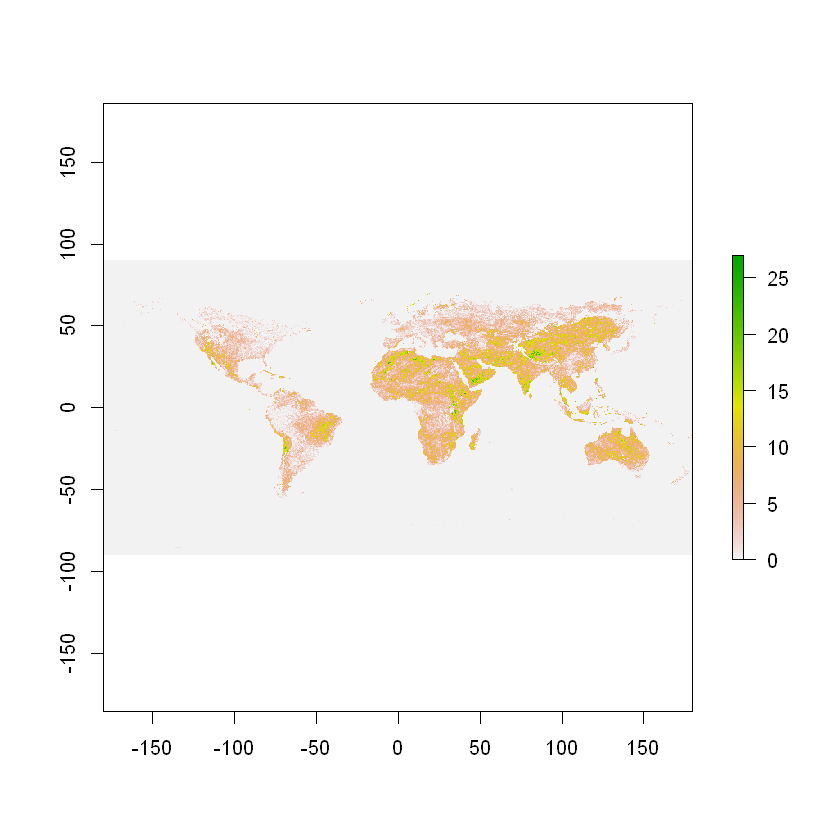

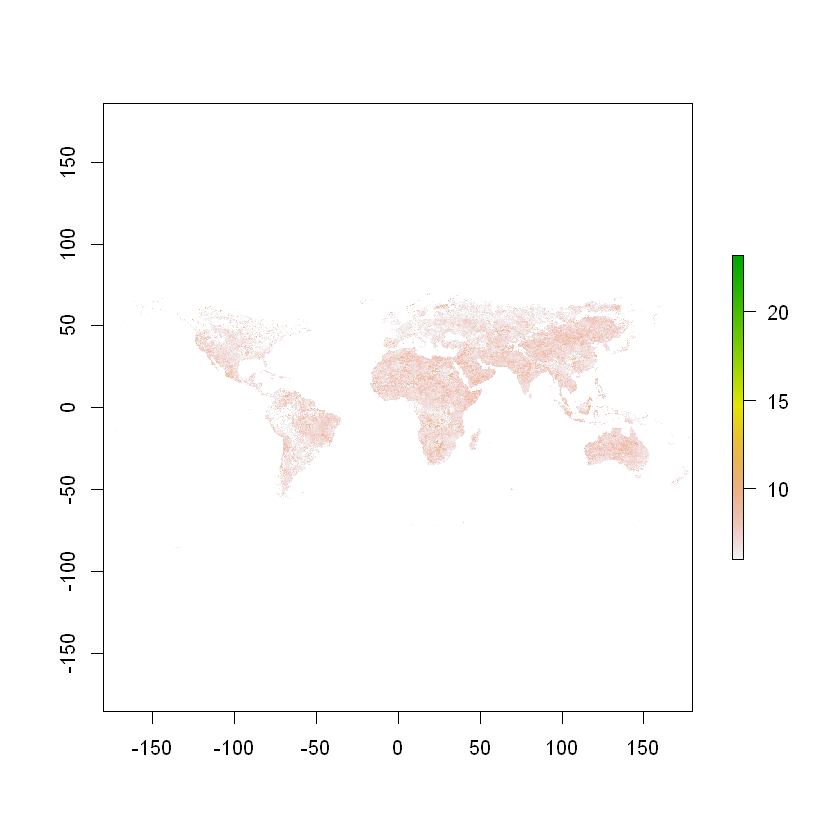

In [7]:
#查看结果
## function for  converting grid data  to raster 
to_raster = function(occ_total,  filename){
  library(raster)
  load(file="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")
  dat = data.frame(x=grid2$lon, y=grid2$lat, z= occ_total)#[(720*5*18+1):(720*5*19)]
  dat_raster = rasterFromXYZ( dat )
  crs(dat_raster) = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
  #pdf(paste0(filename,".pdf"),width = 8, height = 6,)
  plot(dat_raster)
  #dev.off()
  #writeRaster(x=dat_raster, filename=paste0(filename,".nc"), overwrite=T)
}


load(file = "H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
occ_total = rowSums(occ_number, na.rm = T)    #骤旱发生的数量
to_raster(occ_total ,  filename = "occ_total_Christian")

occ_dur = rowMeans(occ_ave_dur, na.rm = T)    #骤旱的持续时间
to_raster(occ_dur  ,  filename = "occ_dur_Christian")


3.4 处理ERA5结果

In [ ]:

############################################################################################################
########################################## Christian methods ###############################################
############################################################################################################
year = 1981:2020
occ_number =  occ_ave_dur =  occ_max_dur = occ_ave_change_prec = 
  occ_max_change_prec =  occ_growth_number = array(NA, dim=c(7200*36, length(year)) )
fd_class <-  fd_month <- array(NA, dim=c(7200*36, length(year),4) )

#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\grid_lon_lat.RData")
data_fd_total=NULL
for(i in 1:36){  # i is the batch name, each batch consists of nlon girds of longitude
  
  #nlon = 5
  #i=19
  filename = paste0( "E:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\flash_drought_directory_",i,".RData" )
  load( filename )
  
  n_grids = 720*10
  #寻找发生骤旱的点
  list1=NULL
  n=1
  for(k in 1:n_grids){
    if(length(unlist(flash_drought_directory[[k]][1]))!=0){
      #flash_drought_directory[[i]]
      print(k)
      list1[n]=k
      n=n+1
    }
  }
  
  #i_grid=7131
  for(i_grid in list1){
    
    ## occurrence numbers
    fd_mean_sesr_change = flash_drought_directory[[i_grid]]$mean_sesr_change
    fd_length = flash_drought_directory[[i_grid]]$fd_length
    fd_intensity = flash_drought_directory[[i_grid]]$fd_intensity
    pre_sesr = flash_drought_directory[[i_grid]]$pre_sesr
    non_moderated_fd = flash_drought_directory[[i_grid]]$non_moderated_fd
    
    occ_year = flash_drought_directory[[i_grid]]$fd_start %/% 73  + year[1]
    # occ_end = flash_drought_directory[[i_grid]]$fd_end %/% 73  + year[1]
    occ_start = flash_drought_directory[[i_grid]]$fd_start%% 73
    #occ_end = flash_drought_directory[[i_grid]]$fd_end%% 73
    ## occurrence times for each year 
    #i_year=17
    data_fd=data.frame(number=((i-1)*n_grids+i_grid),occ_year,occ_start,fd_length,fd_intensity,fd_mean_sesr_change)
    for(i_year in 1:length(year)){
      
      loc = which(occ_year==year[i_year])
      
      if (length(loc)>0 ){
        occ_number[(i-1)*n_grids+i_grid,i_year] = length(loc) 
        #fd_mean_sesr_change [(i-1)*n_grids+i_grid,i_year] = fd_mean_sesr_change[loc]
        occ_ave_dur [(i-1)*n_grids+i_grid,i_year] = mean ( fd_length[loc] )
        occ_max_dur [(i-1)*n_grids+i_grid,i_year] = max ( fd_length[loc] )
        occ_max_change_prec [(i-1)*n_grids+i_grid,i_year] = mean ( fd_mean_sesr_change[loc] )
        occ_ave_change_prec [(i-1)*n_grids+i_grid,i_year] = max ( fd_mean_sesr_change[loc] )
        
        fd_intensity_year = fd_intensity[loc]
        fd_class [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_intensity_year[ fd_intensity_year == 4 ] )  # number of flash drought events belonging to category #4
        fd_class [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_intensity_year[ fd_intensity_year == 3 ] )  # number of flash drought events belonging to category #3
        fd_class [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_intensity_year[ fd_intensity_year == 2 ] )  # number of flash drought events belonging to category #2
        fd_class [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_intensity_year[ fd_intensity_year == 1 ] )  # number of flash drought events belonging to category #1
        
        fd_occ_month = occ_start[loc]
        fd_month [(i-1)*n_grids+i_grid,i_year,4] = length ( fd_occ_month[ fd_occ_month %in% c(0:12,67:72) ] )  #spring
        fd_month [(i-1)*n_grids+i_grid,i_year,3] = length ( fd_occ_month[ fd_occ_month %in% c(13:28) ] )  # summer
        fd_month [(i-1)*n_grids+i_grid,i_year,2] = length ( fd_occ_month[ fd_occ_month %in% c(29:47) ] )  # autumn
        fd_month [(i-1)*n_grids+i_grid,i_year,1] = length ( fd_occ_month[ fd_occ_month %in% c(48:66) ] )  #winter
      }
      
    }
     data_fd_total=rbind(data_fd_total,data_fd)
  }
  print(i)
}
# save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
#      occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
#      file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
save(occ_number,  occ_ave_dur,  occ_max_dur, occ_ave_change_prec,
      occ_max_change_prec,  occ_growth_number,   fd_class , fd_month,
      file = "E:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\fd_characteristics_detrend.RData")

save(data_fd_total,
      file = "E:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData")


[1] 1
[1] 1720
[1] 1721
[1] 1722
[1] 1723
[1] 1724
[1] 1725
[1] 1726
[1] 1727
[1] 1728
[1] 1729
[1] 1730
[1] 1731
[1] 1732
[1] 1733
[1] 1734
[1] 1735
[1] 1736
[1] 1737
[1] 1738
[1] 1739
[1] 1740
[1] 1741
[1] 1742
[1] 1743
[1] 1744
[1] 1745
[1] 1746
[1] 1747
[1] 1748
[1] 2361
[1] 2366
[1] 2367
[1] 2368
[1] 2369
[1] 2370
[1] 2375
[1] 2376
[1] 2377
[1] 2379
[1] 2380
[1] 2382
[1] 2383
[1] 2426
[1] 2427
[1] 2428
[1] 2430
[1] 2431
[1] 2432
[1] 2433
[1] 2436
[1] 2437
[1] 2438
[1] 2439
[1] 2440
[1] 2441
[1] 2468
[1] 2470
[1] 2471
[1] 3076
[1] 3078
[1] 3115
[1] 3116
[1] 3142
[1] 3143
[1] 3144
[1] 3145
[1] 3146
[1] 3147
[1] 3148
[1] 3149
[1] 3150
[1] 3194
[1] 3196
[1] 3197
[1] 3782
[1] 3783
[1] 3784
[1] 3785
[1] 3843
[1] 3844
[1] 3845
[1] 3846
[1] 3847
[1] 3865
[1] 3866
[1] 3867
[1] 3910
[1] 3911
[1] 3913
[1] 3914
[1] 3917
[1] 3922
[1] 4492
[1] 4494
[1] 4495
[1] 4497
[1] 4498
[1] 4499
[1] 4549
[1] 4550
[1] 4551
[1] 4552
[1] 4553
[1] 4554
[1] 4555
[1] 4556
[1] 4557
[1] 4558
[1] 4578
[1] 4579
[1] 

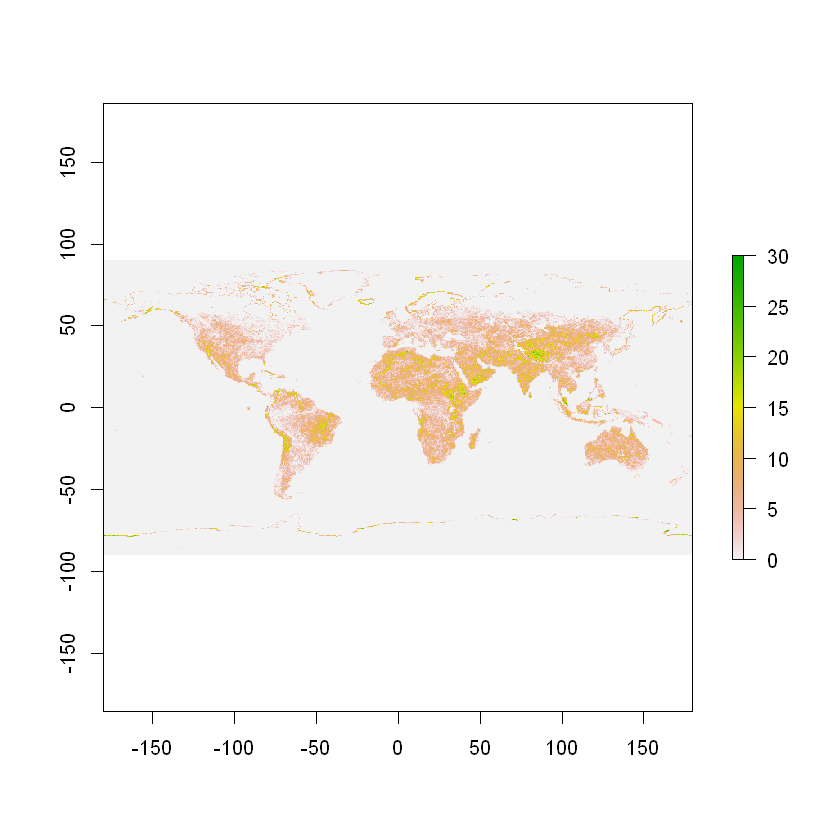

In [9]:
#查看结果
## function for  converting grid data  to raster 
to_raster = function(occ_total,  filename){
  load(file="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")
  dat = data.frame(x=grid2$lon, y=grid2$lat, z= occ_total)#[(720*5*18+1):(720*5*19)]
  dat_raster = rasterFromXYZ( dat )
  crs(dat_raster) = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
  #pdf(paste0(filename,".pdf"),width = 8, height = 6,)
  plot(dat_raster)
  #dev.off()
  #writeRaster(x=dat_raster, filename=paste0(filename,".nc"), overwrite=T)
}


load(file = "H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\fd_characteristics_detrend.RData")
occ_total = rowSums(occ_number, na.rm = T)    #骤旱发生的数量
to_raster(occ_total ,  filename = "occ_total_Christian")


3.5.结果附加处理(增加日期，月份，序号)

In [ ]:
#增加日期，月份，序号
fun1 <- function(file_name){
load(file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")  
grid2$number <- seq(1,dim(grid2)[1],1)
load(paste0(file_name,"data_fd_total.RData"))
for(i in 1:dim(data_fd_total)[1]){
if(data_fd_total$occ_start[i]==0){
  data_fd_total$occ_start[i]=73
}
}
data_fd_total$DATE <- as.Date(paste0(data_fd_total[,2],"-1-1"))+as.numeric((data_fd_total[,3]-1)*5)  #添加日期
data_fd_total$month <- format(as.POSIXlt(data_fd_total$DATE),"%m")       
data_fd_total <- dplyr::right_join(grid2,data_fd_total,by="number")
save(data_fd_total,file=paste0(file_name,"data_fd_total1.RData"))
}


In [ ]:
file_name <- "H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\"
fun1(file_name)
file_name <- "H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\"
fun1(file_name)
file_name <-"H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\"
fun1(file_name)

3.6.计算三个数据集(ERA5,ERA5-LAND,GLEAM)的骤旱结果平均值

In [ ]:
load("E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
occ_number1=occ_number
occ_ave_dur1=occ_ave_dur
occ_max_dur1=occ_max_dur
occ_ave_change_prec1=occ_ave_change_prec
occ_max_change_prec1=occ_max_change_prec
occ_growth_number1=occ_growth_number
fd_class1=fd_class
fd_month1=fd_month
load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_characteristics_detrend.RData")
occ_number2=occ_number
occ_ave_dur2=occ_ave_dur
occ_max_dur2=occ_max_dur
occ_ave_change_prec2=occ_ave_change_prec
occ_max_change_prec2=occ_max_change_prec
occ_growth_number2=occ_growth_number
fd_class2=fd_class
fd_month2=fd_month
load("E:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\fd_characteristics_detrend.RData")
fun=function(data,data1,data2){
  data3=matrix(NA,nrow=dim(data)[1],ncol=dim(data)[2])
  m=dim(data3)
for(i in 1:m[2]){
  for(j in 1:m[1]){
  if(!is.na(data1[j,i])|!is.na(data2[j,i])|!is.na(data[j,i])){
    data3[j,i]=mean(c(data1[j,i],data2[j,i],data[j,i]),na.rm=T)#
  }
  }
  print(i)
}
return(data3)
}

occ_number=fun(occ_number,occ_number1,occ_number2)
occ_ave_dur=fun(occ_ave_dur,occ_ave_dur1,occ_ave_dur2)
occ_max_dur=fun(occ_max_dur,occ_max_dur1,occ_max_dur2)
occ_ave_change_prec=fun(occ_ave_change_prec,occ_ave_change_prec1,occ_ave_change_prec2)
occ_growth_number=fun(occ_growth_number,occ_growth_number1,occ_growth_number2)
#强度和月份区平均值是否合理？？不合理
i=1
fd_class[,,i]=fun(fd_class[,,i],fd_class1[,,i],fd_class2[,,i])
i=2
fd_class[,,i]=fun(fd_class[,,i],fd_class1[,,i],fd_class2[,,i])
i=3
fd_class[,,i]=fun(fd_class[,,i],fd_class1[,,i],fd_class2[,,i])
i=4
fd_class[,,i]=fun(fd_class[,,i],fd_class1[,,i],fd_class2[,,i])

i=1
fd_month[,,i]=fun(fd_month[,,i],fd_month1[,,i],fd_month2[,,i])
i=2
fd_month[,,i]=fun(fd_month[,,i],fd_month1[,,i],fd_month2[,,i])
i=3
fd_month[,,i]=fun(fd_month[,,i],fd_month1[,,i],fd_month2[,,i])
i=4
fd_month[,,i]=fun(fd_month[,,i],fd_month1[,,i],fd_month2[,,i])

save(occ_number,occ_ave_dur,occ_max_dur,occ_ave_change_prec,occ_growth_number,fd_class,fd_month,
     file="E:\\NO.1 flash drought\\03data\\data_GEE5\\fd_characteristics_detrend.RData")

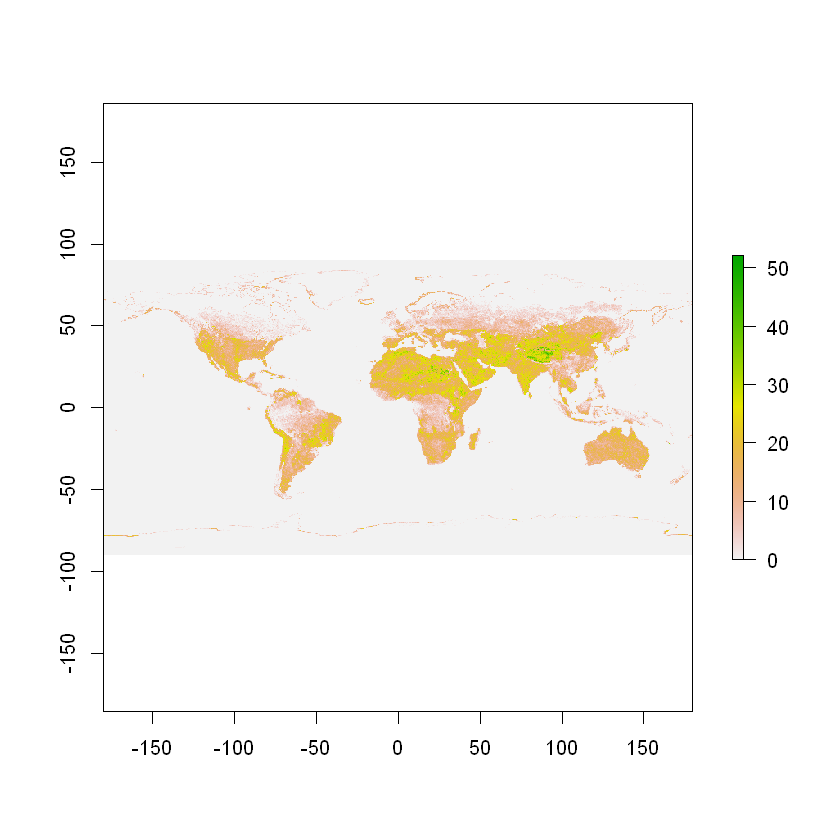

In [ ]:
## function for  converting grid data  to raster 
to_raster = function(occ_total,  filename){
  load(file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")
  dat = data.frame(x=grid2$lon, y=grid2$lat, z= occ_total)#[(720*5*18+1):(720*5*19)]
  dat_raster = rasterFromXYZ( dat )
  crs(dat_raster) = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
  #pdf(paste0(filename,".pdf"),width = 8, height = 6,)
  plot(dat_raster)
  #dev.off()
  #writeRaster(x=dat_raster, filename=paste0(filename,".nc"), overwrite=T)
}

library(raster)
load(file = "E:\\NO.1 flash drought\\03data\\data_GEE5\\fd_characteristics_detrend.RData")
occ_total = rowSums(occ_number, na.rm = T)    #骤旱发生的数量
to_raster(occ_total ,  filename = "occ_total_Christian")

4.骤旱分析==============================

In [ ]:
#此处分析见2.FD_RESULT_TREATMENT.ipynb文件

5.导入其他气象变量的数据===================================

In [ ]:
#处理步骤
#1.匹配时间
#2.将日数据变为pentad数据
#3.数据清洗
#4.数据标准化
#5.将所有发生骤旱的点的变量数据合并为一个文件
#6.提取骤旱发生前后两个pentad的值

5.1处理GLEAM-SM数据

In [ ]:
#数据清洗以及数据标准化
fname="H:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fyear.R"))
source("H:\\NO.1 flash drought\\04code\\6.R_code\\4.paper_function.R")
#i_batch=19

for(i_batch in 1:36){
load(paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\sm1\\sm_resample_",i_batch,".RData"))
dim(sm_resample_1)#720*10   1981-2020   #导入重采样数据
year=1981:2020
time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
m = dim(sm_resample_1)

pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
#j=3879
#k=3

eta=sm_resample_1

for(j in 1:m[1]){
  eta1 = eta[j,]     #提取每一行,一个格点的日数据
  if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {  #排除格点数据缺失量大于10%的格点
      dat = data_clean_data (vtime=time,var=eta1, threshold = 1)  #进行数据清洗+数据插值+数据变为pentad/year格式
      dat_series = as.vector(dat$pentad_matrix)
      if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){#(这句可删除，验证发现对结果基本没有影响)
        pentad.data[j, ] = dat_series
        pentad.data.z[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )  #数据进行标准化
        print("Pass the data clean!")
    }
  }
}
save(pentad.data,pentad.data.z,file=paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\sm2\\pentad.data.z_",i_batch,".RData"))
}


In [17]:
#数据合并
#filename="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine=function(var,var_file,data_name,filename){
load(filename)
data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
fd_order <- unique(data_fd_total$number)  #发生骤旱的点

#var=sm
#var_file=sm2
#fun_combine=function(var,var_file){
data_var_fd=NULL
for(i_batch in 1:36){
#i_batch=10
load(paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\",var_file,"\\pentad.data.z_",i_batch,".RData"))
data=pentad.data.z
number <- c((i_batch-1)*7200+1):(i_batch*7200)
data_var <- data.frame(number,data)
#dim(pentad.data.z)
data_var_fd1 <- data_var[which(data_var$number%in%fd_order),]  #发生骤旱点的土壤湿度数据
data_var_fd <- rbind(data_var_fd,data_var_fd1)
print(i_batch)
}
save(data_var_fd,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
var,"_fd_",data_name,".RData") )#所有发生骤旱点的土壤湿度数据
}


In [ ]:
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("sm","sm2","ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("sm","sm2","ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("sm","sm2","GLEAM",filename3)


In [3]:
 ##提取骤旱的发生前后变量发生的情况
fun <- function(data){   #提取骤旱的发生时变量值
  cc=NULL
  for(i in 1:dim(data)[1]){
    c1 <- (c(data[i,7]:data[i,8]))
    cc <- c(cc,c1)
  }
  return(cc)
}


fun_lag=function(var,data_name,file_name){  #提取骤旱的发生前后变量发生的情况
  fname=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
                 var,"_fd_",data_name,".RData")
  load(fname)
  load(file_name)
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  library(dplyr)
  #1)骤旱发生时的变量值
  fd_var=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    pentad_var <- fun(data)
    fd_var1=data_var_fd[k,pentad_var+1]   #发生骤旱时的土壤湿度
    fd_var <- c(fd_var,fd_var1)
    n=k/length(fd_order)
    print(n)
  }
  
  #2)骤旱发生前一个pentad时的变量值
  fd_var_lag=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    pentad_var <- data$start_pentad-1
    fd_var_lag1 <- data_var_fd[k,pentad_var+1]   #发生骤旱时的土壤湿度
    fd_var_lag <- c(fd_var_lag,fd_var_lag1)
    n=k/length(fd_order)
    print(n)
  }
  
  #3)骤旱发生前2个pentad时的变量值
  fd_var_lag_2=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    pentad_var <- data$start_pentad-2
    fd_var_lag1 <- data_var_fd[k,pentad_var+1]   #发生骤旱时的土壤湿度
    fd_var_lag_2 <- c(fd_var_lag_2,fd_var_lag1)
    n=k/length(fd_order)
    print(n)
  }
  
  #4)骤旱发生后一个pentad时的变量值
  fd_var_lag_3=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    pentad_var <- data$end_pentad+1
    fd_var_lag1 <- data_var_fd[k,pentad_var+1]   #发生骤旱时的土壤湿度
    fd_var_lag_3 <- c(fd_var_lag_3,fd_var_lag1)
    n=k/length(fd_order)
    print(n)
  }
  
  #5)骤旱发生后2个pentad时的变量值
  fd_var_lag_4=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2919),] 
    pentad_var <- data$end_pentad+2
    fd_var_lag1 <- data_var_fd[k,pentad_var+1]   #发生骤旱时的土壤湿度
    fd_var_lag_4 <- c(fd_var_lag_4,fd_var_lag1)
    n=k/length(fd_order)
    print(n)
  }
  
  var_data <- c(unlist(fd_var),unlist(fd_var_lag),unlist(fd_var_lag_2),unlist(fd_var_lag_3),unlist(fd_var_lag_4))
  var_name <- c(rep("Onset",length(fd_var)),rep("Lag+1",length(fd_var_lag)),rep("Lag+2",length(fd_var_lag_2)),
                rep("Lag-1",length(fd_var_lag_3)),rep("Lag-2",length(fd_var_lag_4)))
  var_data_1 <- data.frame(var_name,var_data)
  save(var_data_1,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var,"_data_1_",data_name,".RData"))
  
}


In [ ]:
file_name="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_lag("sm","ERA5LAND",file_name)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_lag("sm","ERA5",file_name2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_lag("sm","GLEAM",file_name3)

5.2导入GLEAM-ET数据

In [ ]:
#数据清洗以及数据标准化
fname="E:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fyear.R"))
source("E:\\NO.1 flash drought\\04code\\6.R_code\\4.paper_function.R")
#i_batch=19

for(i_batch in 1:36){
load(paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\eta1\\eta_resample_",i_batch,".RData"))
dim(et_resample_1)#720*10   1981-2020
year=1981:2020
time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
m = dim(et_resample_1)

pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
#j=3879
#k=3
eta=et_resample_1

for(j in 1:m[1]){
  #for (k in 1:m[2]) {
  eta1 = eta[j,]
  #eta1[eta1<0] = NA
  if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {
   # if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
      dat = data_clean_data (vtime=time,var=eta1, threshold = 1)
      #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
      dat_series = as.vector(dat$pentad_matrix)
      if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
        pentad.data[j, ] = dat_series
        pentad.data.z[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
        #pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
        print("Pass the data clean!")
      #}
    }
  }
}
save(pentad.data,pentad.data.z,file=paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\eta2\\pentad.data.z_",i_batch,".RData"))
}

#数据合并
pentad.data.z1=NULL
for(i in 1:36){  # i is the batch name, each batch consists of nlon girds of longitude
  #i_batch=19
  filename = paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\eta2\\pentad.data.z_",i_batch,".RData")
  load( filename )
  pentad.data.z1=rbind(pentad.data.z1,pentad.data.z)
}

save(pentad.data.z1,file=paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\eta2\\pentad.data.z_total.RData"))


In [ ]:
#数据合并(不要)
#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_characteristics_detrend.RData")
load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData")
data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
fd_order <- unique(data_fd_total$number)  #发生骤旱的点

var=et
var_file=eta2
fun_combine(var,var_file)

In [18]:
#数据合并
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("et","eta2","ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("et","eta2","ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("et","eta2","GLEAM",filename3)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36


In [ ]:
#提取骤旱的发生前后变量发生的情况
fun_lag(et)

In [ ]:
#提取骤旱的发生前后变量发生的情况
file_name="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_lag("et","ERA5LAND",file_name)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_lag("et","ERA5",file_name2)

#filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
#fun_lag("et","GLEAM",file_name3)

5.3导入GLEAM-PET数据

In [18]:
#数据清洗以及数据标准化
fname="E:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fyear.R"))
source("E:\\NO.1 flash drought\\04code\\6.R_code\\4.paper_function.R")
#i_batch=19

for(i_batch in 1:36){
load(paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\pet1\\pet_resample_",i_batch,".RData"))
dim(pet_resample_1)#720*10   1981-2020
year=1981:2020
time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
m = dim(pet_resample_1)

pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
#j=3879
#k=3
eta=pet_resample_1

for(j in 1:m[1]){
  #for (k in 1:m[2]) {
  eta1 = eta[j,]
  #eta1[eta1<0] = NA
  if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {
   # if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
      dat = data_clean_data (vtime=time,var=eta1, threshold = 1)
      #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
      dat_series = as.vector(dat$pentad_matrix)
      if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
        pentad.data[j, ] = dat_series
        pentad.data.z[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
        #pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
        print("Pass the data clean!")
      #}
    }
  }
}
save(pentad.data,pentad.data.z,file=paste0("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\pet2\\pentad.data.z_",i_batch,".RData"))
}


[1] "data.frame"

[1]  586 2850

lon_lat          V1         V2         V3         V4         V5        
3899 (82.875,-82.625) -0.5664540 -0.5688053 -0.5782103 -0.5735078 -0.5664540
3900 (82.625,-82.625) -0.5273256 -0.5343707 -0.5437641 -0.5367190 -0.5296739
3909 (82.875,-82.375) -0.5637916 -0.5684959 -0.5755524 -0.5708481 -0.5661438
3910 (82.625,-82.375) -0.5253772 -0.5323948 -0.5417516 -0.5323948 -0.5253772
3919 (82.875,-82.125) -0.5610590 -0.5657668 -0.5751825 -0.5704747 -0.5634129
3920 (82.625,-82.125) -0.5220814 -0.5313404 -0.5382847 -0.5313404 -0.5220814
     V6         V7         V8         V9         ... V2840      V2841     
3899 -0.6181818 -0.5735078 -0.5805616 -0.5735078 ... -0.5641028 -0.5546977
3900 -0.5719445 -0.5508092 -0.5555059 -0.5508092 ... -0.5414158 -0.5343707
3909 -0.6155392 -0.5732003 -0.5802567 -0.5732003 ... -0.5637916 -0.5543830
3910 -0.5674828 -0.5464300 -0.5534476 -0.5440908 ... -0.5370732 -0.5323948
3919 -0.6128452 -0.5704747 -0.5775364 -0.5728286 ... -0.5610590 -0.5516433
3920 -0.5637470 -0.5452290 -0.5521732 -0.5405994 ... -0.5336552 -0.5313404
     V2842      V2843      V2844      V2845      V2846      V2847     
3899 -0.5405901 -0.5688053 -0.5405901 -0.5476439 -0.5311851 -0.5570490
3900 -0.5296739 -0.5531576 -0.5249772 -0.5437641 -0.5320223 -0.5437641
3909 -0.5402700 -0.5661438 -0.5402700 -0.5473265 -0.5308613 -0.5567351
3910 -0.5277164 -0.5511084 -0.5230380 -0.5394124 -0.5300556 -0.5417516
3919 -0.5398737 -0.5657668 -0.5375198 -0.5445816 -0.5304580 -0.5563512
3920 -0.5267109 -0.5475437 -0.5220814 -0.5382847 -0.5290257 -0.5405994
     V2848      V2849     
3899 -0.5429414 -0.5946692
3900 -0.5320223 -0.5719445
3909 -0.5426221 -0.5943697
3910 -0.5300556 -0.5698220
3919 -0.5398737 -0.5916599
3920 -0.5290257 -0.5660618

In [ ]:
#数据合并
#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_characteristics_detrend.RData")
load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData")
data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
fd_order <- unique(data_fd_total$number)  #发生骤旱的点

var=pet
var_file=pet2
fun_combine(var,var_file)


In [19]:
#数据合并
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("pet","pet2","ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("pet","pet2","ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("pet","pet2","GLEAM",filename3)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36


In [ ]:
##提取骤旱的发生前后变量发生的情况
fun_lag(pet)

In [4]:
#提取骤旱的发生前后变量发生的情况
file_name="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_lag("pet","ERA5LAND",file_name)



载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] 2.49389e-05
[1] 4.98778e-05
[1] 7.48167e-05
[1] 9.97556e-05
[1] 0.0001246945
[1] 0.0001496334
[1] 0.0001745723
[1] 0.0001995112
[1] 0.0002244501
[1] 0.000249389
[1] 0.0002743279
[1] 0.0002992668
[1] 0.0003242057
[1] 0.0003491446
[1] 0.0003740835
[1] 0.0003990224
[1] 0.0004239613
[1] 0.0004489002
[1] 0.0004738391
[1] 0.000498778
[1] 0.0005237169
[1] 0.0005486558
[1] 0.0005735947
[1] 0.0005985336
[1] 0.0006234725
[1] 0.0006484114
[1] 0.0006733503
[1] 0.0006982892
[1] 0.0007232281
[1] 0.000748167
[1] 0.0007731059
[1] 0.0007980448
[1] 0.0008229837
[1] 0.0008479226
[1] 0.0008728615
[1] 0.0008978004
[1] 0.0009227393
[1] 0.0009476782
[1] 0.0009726171
[1] 0.000997556
[1] 0.001022495
[1] 0.001047434
[1] 0.001072373
[1] 0.001097312
[1] 0.00112225
[1] 0.001147189
[1] 0.001172128
[1] 0.001197067
[1] 0.001222006
[1] 0.001246945
[1] 0.001271884
[1] 0.001296823
[1] 0.001321762
[1] 0.001346701
[1] 0.001371639
[1] 0.001396578
[1] 0.001421517
[1] 0.001446456
[1] 0.001471395
[1] 0.001496334
[1] 0.001

In [ ]:

file_name2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_lag("pet","ERA5",file_name2)

#file_name3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
#fun_lag("pet","GLEAM",file_name3)

5.5处理ERA5-T数据

In [ ]:
library(ncdf4)
library(raster)

sample<- raster(xmn=0, xmx=360, ymn=-90, ymx=90, 
                resolution=0.5, vals=NULL)  
fun<-function(x){
  dat<-mean(x)-273.15
  return(dat)
}
#蒸发数据批处理
#服务器
#YEAR=1991


#对ET进行数据清洗并且合并数据（一年一个文件）（服务器处理）
ET_FUN=function(YEAR){
  #ffname=paste0("/scratch/xtan/dsm_3/ERA5/E/",YEAR)
  ffname=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T\\",YEAR)
  setwd(ffname)
  file_name<-list.files(ffname)
  #批处理(数据清洗)
  file=1
  et_file <- brick(file_name[file],varname="t2m")  #注意要选择变量
  et_daily_data <- calc(et_file,fun)  
  #et_daily_data = NULL
  for(file in 2:length(file_name)){#
    et_file <- brick(file_name[file],varname="t2m")  #注意要选择变量
    et_daily_file <- calc(et_file,fun)               #计算日蒸发量
    et_daily_data <- stack(et_daily_data,et_daily_file)
    print(file)
  }
  #et_daily_data
  #数据重采样
  # library(raster)
  et_inter <- resample(et_daily_data,sample, method='bilinear')   #进行重采样，一年
  #save(et_inter,file="E:\\NO.1 flash drought\\03data\\ERA5\\et_inter.RData")
  
  #转换坐标
  class(et_inter)
  x1=crop(et_inter,extent(0,180,-90,90))
  x2=crop(et_inter,extent(180,360,-90,90))
  extent(x2)=c(-180,0,-90,90)
  et_inter_data=merge(x2,x1)#
  #plot(et_inter_data)
  
  #save(et_inter_data,file=paste0("/scratch/xtan/dsm_3/ERA5/E/ERA5-ET/ET1/et_inter_0.5_",YEAR,".RData"))
  save(et_inter_data,file=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T1\\et_inter_0.5_",YEAR,".RData"))
  print(YEAR)
  return(YEAR)
}

sapply(1981:2020,ET_FUN)


In [ ]:
#合成et_clean_inter代码（分成36个文件的1981-2020年的数据文件）
library(raster)
library(abind)
file_name_2=list.files("I:\\1.data_file\\10气象数据\\ERA5\\T1")
# file_name_1 <- grep("et_inter_0.5_.",file_name,value=T)
# file_name_2= paste0("/scratch/xtan/dsm_3/ERA5_Land/E/",file_name_1)
setwd("I:\\1.data_file\\10气象数据\\ERA5\\T1")
for(i in 1:36){
  load(file_name_2[1])
  et_clean_inter_1=et_inter_data[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    et_clean_inter_1=abind(et_clean_inter_1,et_inter_data[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(et_clean_inter_1,file=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T2\\et_clean_data_",i,".RData"))
}

In [ ]:
#数据清洗以及数据标准化
fname="H:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fyear.R"))
source("H:\\NO.1 flash drought\\04code\\6.R_code\\4.paper_function.R")
#i_batch=19

for(i_batch in 1:36){
  load(paste0("I:\\1.data_file\\10气象数据\\ERA5\\T2\\et_clean_data_",i_batch,".RData"))
   #dim(et_resample_1)#720*10   1981-2020
  year=1981:2020
  time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
  m = dim(et_clean_inter_1)
  
  pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
  #j=3879
  #k=3
  eta=et_clean_inter_1
  
  for(j in 1:m[1]){
    #for (k in 1:m[2]) {
    eta1 = eta[j,]
    #eta1[eta1<0] = NA
    if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {
      # if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
      dat = data_clean_data_mean (vtime=time,var=eta1, threshold = 1)   #！！注意该部分分温度有可能小于0，公式要修改
      #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
      dat_series = as.vector(dat$pentad_matrix)
      if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
        pentad.data[j, ] = dat_series
        pentad.data.z[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
        #pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
        #print("Pass the data clean!")
        }
      }
    }
  
  save(pentad.data,pentad.data.z,file=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T3\\pentad.data.z_",i_batch,".RData"))
}


In [3]:
#数据合并
pentad.data.z1=NULL
for(i_batch in 1:36){  # i is the batch name, each batch consists of nlon girds of longitude
  #i_batch=19
  filename = paste0("I:\\1.data_file\\10气象数据\\ERA5\\T3\\pentad.data.z_",i_batch,".RData")
  load( filename )
  pentad.data.z1=rbind(pentad.data.z1,pentad.data.z)
}

save(pentad.data.z1,file=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T3\\pentad.data.z_total.RData"))


In [5]:
#数据合并(调出骤旱数据进行合并，减小内存)（不要）
#load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\fd_characteristics_detrend.RData")
load("E:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData")
data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
fd_order <- unique(data_fd_total$number)  #发生骤旱的点

fun_combine=function(var,var_file){
data_var_fd=NULL
for(i_batch in 1:36){
#i_batch=10
load(paste0(var_file,"pentad.data.z_",i_batch,".RData"))
data=pentad.data.z
number <- c((i_batch-1)*7200+1):(i_batch*7200)
data_var <- data.frame(number,data)
#dim(pentad.data.z)
data_var_fd1 <- data_var[which(data_var$number%in%fd_order),]  #发生骤旱点的土壤湿度数据
data_var_fd <- rbind(data_var_fd,data_var_fd1)
print(i_batch)
}
save(data_var_fd,file=paste0("E:\\NO.1 flash drought\\03data\\meteorological\\data_",var,"_fd.RData") )#所有发生骤旱点的土壤湿度数据
}

var="t2m"
var_file="I:\\1.data_file\\10气象数据\\ERA5\\T3\\"
fun_combine(var,var_file)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36


In [21]:
fun_combine=function(var,var_file,data_name,filename){
  load(filename)
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  #var=sm
  #var_file=sm2
  #fun_combine=function(var,var_file){
  data_var_fd=NULL
  for(i_batch in 1:36){
    #i_batch=10
    load(paste0(var_file,"pentad.data.z_",i_batch,".RData"))
    data=pentad.data.z
    number <- c((i_batch-1)*7200+1):(i_batch*7200)
    data_var <- data.frame(number,data)
    #dim(pentad.data.z)
    data_var_fd1 <- data_var[which(data_var$number%in%fd_order),]  #发生骤旱点的土壤湿度数据
    data_var_fd <- rbind(data_var_fd,data_var_fd1)
    print(i_batch)
  }
  save(data_var_fd,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
                               var,"_fd_",data_name,".RData") )#所有发生骤旱点的土壤湿度数据
}



In [ ]:
#数据合并
var_file="I:\\1.data_file\\10气象数据\\ERA5\\T3\\"
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("t2m",var_file,"ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("t2m",var_file,"ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("t2m",var_file,"GLEAM",filename3)

In [10]:
#提取骤旱的发生前后变量发生的情况
fun_lag("t2m")

ERROR: Error in filter(data_fd_total, number == fd_order[k]): 找不到对象'number'


In [ ]:
file_name="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_lag("t2m","ERA5LAND",file_name)


file_name2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_lag("t2m","ERA5",file_name2)

#filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
#fun_lag("t2m","GLEAM",file_name3)

####进行重新计算SM/ET/PET/T

#1）数据清洗和标准化

In [2]:
#（对SM/ET/PET/T都重新算过了）
fname="H:\\NO.1 flash drought\\04code\\2.R_copyTX\\function"
source(paste0(fname,"/fanomaly.R"))
source(paste0(fname,"/fpentad.R"))
source(paste0(fname,"/fpercentile.R"))
source(paste0(fname,"/fyear.R"))
source("H:\\NO.1 flash drought\\04code\\6.R_code\\4.paper_function.R")
library(dplyr)
#i_batch=3
for(i_batch in 1:36){
  #导入重采样过的日数据
  #load(paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\sm1\\sm_resample_",i_batch,".RData"))
  #load(paste0("H:\NO.1 flash drought\03data\gleam_v3.5a\6.GLEAM-0.5\eta1\eta_resample_",i_batch,".RData"))
  #load(paste0("H:\NO.1 flash drought\03data\gleam_v3.5a\6.GLEAM-0.5\pet1\pet_resample_",i_batch,".RData"))
  load(paste0("I:\\1.data_file\\10气象数据\\ERA5\\T2\\et_clean_data_",i_batch,".RData"))
  #需修改
  year=1981:2020
  time = seq(from = as.POSIXct('1981-01-01', tz = "GMT"), to = as.POSIXct('2020-12-31', tz = "GMT"), by = 'day')
  m = dim(et_clean_inter_1)
  pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
  eta=et_clean_inter_1 #需修改
  for(j in 1:m[1]){
    eta1 = eta[j,]     #提取每一行,一个格点的日数据
    if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {  #排除格点数据缺失量大于10%的格点
      dat = data_clean_data_mean (vtime=time,var=eta1, threshold = 1)  #进行数据清洗+数据插值+数据变为pentad/year格式
      dat_series = as.vector(dat$pentad_matrix) #变成每个pentad的数据了
      #if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
      pentad.data[j, ] = dat_series
      pentad.data.z[j,  ] <- f.anomaly(dat_series)  #数据进行标准化
      #print("Pass the data clean!")
      #}
    }
    n=j/m[1]
    print(n)
  }
  print(paste0("======================",i_batch))
  #需修改
  #save(pentad.data,pentad.data.z,file=paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\sm2\\pentad.data.z_1_",i_batch,".RData"))
  #save(pentad.data,pentad.data.z,file=paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\eta2\\pentad.data.z_1_",i_batch,".RData"))
  #save(pentad.data,pentad.data.z,file=paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\pet2\\pentad.data.z_1_",i_batch,".RData"))
save(pentad.data,pentad.data.z,file=paste0("I:\\1.data_file\\10气象数据\\ERA5\\T3\\pentad.data.z_1_",i_batch,".RData"))

}


载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] 0.0001388889
[1] 0.0002777778
[1] 0.0004166667
[1] 0.0005555556
[1] 0.0006944444
[1] 0.0008333333
[1] 0.0009722222
[1] 0.001111111
[1] 0.00125
[1] 0.001388889
[1] 0.001527778
[1] 0.001666667
[1] 0.001805556
[1] 0.001944444
[1] 0.002083333
[1] 0.002222222
[1] 0.002361111
[1] 0.0025
[1] 0.002638889
[1] 0.002777778
[1] 0.002916667
[1] 0.003055556
[1] 0.003194444
[1] 0.003333333
[1] 0.003472222
[1] 0.003611111
[1] 0.00375
[1] 0.003888889
[1] 0.004027778
[1] 0.004166667
[1] 0.004305556
[1] 0.004444444
[1] 0.004583333
[1] 0.004722222
[1] 0.004861111
[1] 0.005
[1] 0.005138889
[1] 0.005277778
[1] 0.005416667
[1] 0.005555556
[1] 0.005694444
[1] 0.005833333
[1] 0.005972222
[1] 0.006111111
[1] 0.00625
[1] 0.006388889
[1] 0.006527778
[1] 0.006666667
[1] 0.006805556
[1] 0.006944444
[1] 0.007083333
[1] 0.007222222
[1] 0.007361111
[1] 0.0075
[1] 0.007638889
[1] 0.007777778
[1] 0.007916667
[1] 0.008055556
[1] 0.008194444
[1] 0.008333333
[1] 0.008472222
[1] 0.008611111
[1] 0.00875
[1] 0.008888889
[


载入程辑包：'tibbletime'


The following object is masked from 'package:stats':

    filter




#2）数据合并

In [2]:
fun_combine=function(var,data_name,filename){
  load(filename)
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  #var=sm
  #var_file=sm2
  #fun_combine=function(var,var_file){
  data_var_fd=NULL
  for(i_batch in 1:36){
    var_file="sm2"#需修改
    load(paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\",var_file,"\\pentad.data.z_1_",i_batch,".RData"))
    data=pentad.data.z
    number <- c((i_batch-1)*7200+1):(i_batch*7200)
    data_var <- data.frame(number,data)
    #dim(pentad.data.z)
    data_var_fd1 <- data_var[which(data_var$number%in%fd_order),]  #发生骤旱点的土壤湿度数据
    data_var_fd <- rbind(data_var_fd,data_var_fd1)
    print(i_batch)
  }
  save(data_var_fd,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
                               var,"_fd_1_",data_name,".RData") )#所有发生骤旱点的土壤湿度数据
}


In [3]:
#sm
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("sm","ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("sm","ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("sm","GLEAM",filename3)

In [ ]:
#et
filename1="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_combine("et","ERA5LAND",filename1)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_combine("et","ERA5",filename2)

filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_combine("et","GLEAM",filename3)

In [ ]:
#pet
filename1="/media/xtan/15777115545/temporary/data/result/ERA5LAND/data_fd_total.RData"
fun_combine("pet","ERA5LAND",filename1)

filename2="/media/xtan/15777115545/temporary/data/result/ERA5/data_fd_total.RData"
fun_combine("pet","ERA5",filename2)

filename3="/media/xtan/15777115545/temporary/data/result/GLEAM/data_fd_total.RData"
fun_combine("pet","GLEAM",filename3)

#3）骤旱变化前后的变量

In [4]:
fun <- function(data){   #提取骤旱的发生时变量值
  cc=NULL
  for(i in 1:dim(data)[1]){
    c1 <- (c(data[i,7]:data[i,8]))
    cc <- c(cc,c1)
  }
  return(cc)
}

 fun_lag=function(var,data_name,file_name){  #提取骤旱的发生前后变量发生的情况
  load(file_name)
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
               var,"_fd_1_",data_name,".RData"))#导入发生骤旱的变量
  data_var_fd=data_var_fd[,-1]  #把序号去掉
  
  library(dplyr)
  fd_var=NULL
  fd_var_lag=NULL
  fd_var_lag_2=NULL
  fd_var_lag_3=NULL
  fd_var_lag_4=NULL
  
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2919&data$start_pentad>2),]
    if(dim(data)[1]!=0){
    pentad_var <- fun(data)
    fd_var1=data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
    fd_var <- c(fd_var,fd_var1)
    
    pentad_var <- data$start_pentad-1
    fd_var_lag1 <- data_var_fd[k,pentad_var] 
    fd_var_lag <- c(fd_var_lag,fd_var_lag1)
    
    pentad_var <- data$start_pentad-2       #
    fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
    fd_var_lag_2 <- c(fd_var_lag_2,fd_var_lag1)
    
    pentad_var <- data$end_pentad+1
    fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
    fd_var_lag_3 <- c(fd_var_lag_3,fd_var_lag1)
    
    pentad_var <- data$end_pentad+2
    fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
    fd_var_lag_4 <- c(fd_var_lag_4,fd_var_lag1)
    }
    n=k/length(fd_order)
    print(n)
  }
    var_data <- c(unlist(fd_var),unlist(fd_var_lag),unlist(fd_var_lag_2),unlist(fd_var_lag_3),unlist(fd_var_lag_4))
    var_name <- c(rep("Onset",length(fd_var)),rep("Lag+1",length(fd_var_lag)),rep("Lag+2",length(fd_var_lag_2)),
                  rep("Lag-1",length(fd_var_lag_3)),rep("Lag-2",length(fd_var_lag_4)))
    var_data_1 <- data.frame(var_name,var_data)
    save(var_data_1,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var,"_data_1_1_",data_name,".RData"))
   return(var_data_1)
  }


In [ ]:

var="sm"
data_name="GLEAM"
file_name="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
fun_lag(var,data_name,file_name)

file_name="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
fun_lag("sm","ERA5LAND",file_name)

filename2="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
fun_lag("sm","ERA5",filename2)

#filename3="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
#fun_lag("sm","GLEAM",file_name3)

5.6处理GPP数据(没用到)

In [ ]:
#下载链接https://data.tpdc.ac.cn/en/data/d6dff40f-5dbd-4f2d-ac96-55827ab93cc5/
#lat=-90~90  lon=-180~180
#0.05°
#unit gC m-2 m-1 月尺度 1982-2018

library(ncdf4)
library(abind)
library('dplyr')
#library('tibbletime')
library(stringr)
library(raster)


sample<- raster(xmn=-180, xmx=180, ymn=-90, ymx=90, 
                resolution=0.5, vals=NULL)  

#1)对数据进行重采样，改为0.5*0.5
year=1982
input_path <- "E:/NO.1 flash drought/03data/GPP/LTDR-GPP/"
out_path <-"E:/NO.1 flash drought/03data/GPP/LTDR-GPP-0.5/"

for(year in 1983:2020){
  gpp_filename=list.files(paste0(input_path,year))
  setwd(paste0(input_path,year))
  gpp_raster <- stack(gpp_filename[1],varname="GPP") 
  for(i in 2:12){
  gpp_raster1 <- stack(gpp_filename[i],varname="GPP") #提取多层的raster
  gpp_raster <- stack(gpp_raster,gpp_raster1)
  }
  gpp_resample <- resample(gpp_raster,sample, method='bilinear')   #进行重采样
  save(gpp_resample,file=paste0(out_path,"gpp_resample_month_0.5_",year,".RData"))
}

#2)合并时间序列
library(raster)
library(abind)
file_name=list.files("E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-0.5")
#file_name_1 <- grep("et_inter_0.5_.",file_name,value=T)
file_name_2= paste0("E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-0.5\\",file_name)
#1)分为36段
for(i in 1:36){
  load(file_name_2[1])
  gpp_resample_1=gpp_resample[((i-1)*10+1):(10*i),,]
  for(x in 2:length(file_name_2)){
    load(file_name_2[x])
    gpp_resample_1=abind(gpp_resample_1,gpp_resample[((i-1)*10+1):(10*i),,])
    print(x)
  }
  save(gpp_resample_1,file=paste0("E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-36\\gpp_resample_",i,".RData"))
}
#2）直接计算(不用)
load(file_name_2[1])
gpp_resample_1 <- gpp_resample
for(i in 2:length(file_name_2)){
    load(file_name_2[x])
    gpp_resample_1 <- stack(gpp_resample_1,gpp_resample)
    print(i)
  }
save(gpp_resample_1,file=paste0("E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-36\\gpp_resample_0.RData"))


In [ ]:
#3)匹配骤旱点
load(file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
load(file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")
load(file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData")

if(data_fd_total$occ_start[i]==0){
  data_fd_total$occ_start[i]=73
}
data_fd_total$DATE <- as.Date(paste0(data_fd_total[,2],"-1-1"))+as.numeric((data_fd_total[,3]-1)*5)  #添加日期
data_fd_total$month <- format(as.POSIXlt(data_fd_total$DATE),"%m")           #添加月份

save(data_fd_total,file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total1.RData")


load(file="E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\grid_lon_lat.RData")

#合并所有点的数据
gpp_resample_2 <- NULL
for(i in 1:36){
  load(paste0("E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-36\\gpp_resample_",i,".RData"))
  gpp_resample_2 <- rbind(gpp_resample_2,gpp_resample_1) #7200*444 月数据
  print(i)
}
gpp_resample_data <- data.frame(grid2,gpp_resample_2)         #添加经纬度
gpp_resample_data$order <- seq(1,dim(gpp_resample_data)[1],1)  #添加序号

dim(gpp_resample_data)
save(gpp_resample_data,file="E:\\NO.1 flash drought\\03data\\GPP\\LTDR-GPP-36\\gpp_resample_data.RData")

load("E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total1.RData")

data_fd_total$month_order <- (data_fd_total$occ_year-1982)*12+as.numeric(data_fd_total$month)  #月序号

#为了与GPP数据匹配只保留了1982-2018年的数据
data_fd_total <- data_fd_total[-which(data_fd_total$month_order<0),]
data_fd_total <- data_fd_total[-which(data_fd_total$month_order>(37*12)),]

gpp_resample_data[data_fd_total$number]


load(file = "E:\\NO.1 flash drought\\03data\\ERA5\\1.result\\fd_characteristics_detrend.RData")
#年频率
i=29199
year=1982:2018
k=1

occ_number[i,]
fd_number <- unique(data_fd_total$number)

gpp=list()
  fd=NULL
  n=1
for(i in fd_number){
  aa <- occ_number[i,2:38]
  bb <- which(is.na(aa)==F)
  for(k in bb){
    fd1 <- aa[k]
    fd <- c(fd,fd1)
    gpp1 <- gpp_resample_data[i,((k-1)*12+1+2):(k*12+2)]
    gpp[n] <- list(gpp1)
    n=n+1
  }
  m=i/length(fd_number)
  print(i)
}
  
  i=168954
  
  for(i in 1:189188){
  if(is.na(unlist(gpp[i]))[1]*1==0){
    print(i)
  }
  }
  
168954
fd[which.max(fd)]  



5.7处理MSWEP-P数据

In [ ]:
#MSWEP v2.2 
#分辨率 0.1*0.1
#1978-2017.10
#一个月一个文件，每个文件30层
#1980-1984.2分辨率是0.5*0.5，之后的是0.1*0.1，
#由于为了统一计算，从1985-2016年开始计算
#=======================================
#降雨数据使用重采样不合理，导致数据相似，差别较小，影响最后结果
#进行数据清洗并且合并数据（一年一个文件）
library(ncdf4)
library(raster)
library(stringr)
sample<- raster(xmn=-180, xmx=180, ymn=-90, ymx=90, 
                resolution=0.5, vals=NULL)  
ffname="I:\\1.data_file\\10气象数据\\1降水数据\\MSWEPV2.2\\P"
setwd(ffname)
file_name<-list.files(ffname)
# #YEAR=2012
#1-38==0.5///39-432==0.1
ET_FUN=function(YEAR){
  filename <- str_subset(file_name, paste(YEAR, collapse = "|"))
  et_daily_month <- brick(filename[1],varname="precipitation")  #注意要选择变量
  et_daily_data <- resample(et_daily_month,sample,method='bilinear')
  for(file in 2:12){#
    et_daily_month <- brick(filename[file],varname="precipitation")  #注意要选择变量
    et_daily <- resample(et_daily_month,sample,method='bilinear')
    et_daily_data <- stack(et_daily_data,et_daily)
    print(file)
  }
  save(et_daily_data,file=paste0("I:\\1.data_file\\10气象数据\\1降水数据\\MSWEPV2.2\\P1\\pr_inter_",YEAR,".RData"))
}
sapply(1985:2016,ET_FUN)


In [ ]:
#所有发生骤旱点的土壤湿度数
fun_fd=function(var,data_name,filename){
  load(filename)
  data_fd_total <- data_fd_total[-which(data_fd_total$occ_year<1985|data_fd_total$occ_year>2016),]  #注意：这里多一步的计算只在1985-2016年中
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  data_var_fd=NULL
  for(YEAR in 1985:2016){
    #i_batch=10
    #需修改
    #load(paste0("H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\",var_file,"\\pentad.data.z_1_",i_batch,".RData"))
    load(paste0("I:\\1.data_file\\10气象数据\\1降水数据\\MSWEPV2.2\\P1\\pr_inter_",YEAR,".RData"))
    data=raster::getValues(et_daily_data)
    #dim(data_var_fd);class(data)
    #number <- c((i_batch-1)*7200+1):(i_batch*7200)
    #data_var <- data.frame(number,data)
    #dim(pentad.data.z)
    data_var_fd1 <- data[c(fd_order),]
    #data_var_fd1 <- data_var[which(data_var$number%in%fd_order),]  #发生骤旱点的土壤湿度数据
    data_var_fd <-cbind(data_var_fd,data_var_fd1)
    print(YEAR)
  }
  data_var_fd <- round(data_var_fd,3)   #留下发生骤旱的P
  save(data_var_fd,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
                               var,"_fd_1_",data_name,".RData") )#所有发生骤旱点的土壤湿度数
}


In [ ]:
filename="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
var="P"
data_name="GLEAM"
fun_fd(var,data_name,filename)

filename="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
#fun_lag("sm","ERA5LAND",file_name)
var="P"
data_name="ERA5LAND"
fun_fd(var,data_name,filename)

filename="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
#fun_lag("sm","ERA5",filename2)
var="P"
data_name="ERA5"
fun_fd(var,data_name,filename)

In [5]:
#计算p的pentad值，并进行数据的清洗和插值
fun_pentad=function(data_name){
load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
       "P","_fd_1_",data_name,".RData") )  #骤旱发生的日降水值

m=dim(data_var_fd)
  
year=1985:2016
time = seq(from = as.POSIXct('1985-01-01', tz = "GMT"), to = as.POSIXct('2016-12-31', tz = "GMT"), by = 'day')

pentad.data = pentad.data.z= matrix(NA, nrow=m[1], ncol=(length(year) * 73 ))  #7200*2920
#j=3879
#k=3
eta=data_var_fd

for(j in 1:m[1]){
  #for (k in 1:m[2]) {
  eta1 = eta[j,]
  #eta1[eta1<0] = NA
  if (length(eta1[is.na(eta1)]) < 0.1 * m[2] ) {
    # if (! mean(eta1, na.rm = T) == mean(pet1, na.rm = T)  ){
    dat = data_clean_data (vtime=time,var=eta1, threshold = 1)  
    #注意根据不同的变量修改公式，有些变量是5天平均，有些是求和
    #  output <- list('pentad_timestamp' = series.esr, 'pentad_matrix' = pentad.esr)
    dat_series = as.vector(dat$pentad_matrix)
    if( length(dat_series[dat_series==1]) < 0.1* length(dat_series) ){
      pentad.data[j, ] = dat_series
      pentad.data.z[j,  ] <- as.vector( t(apply(dat$pentad_matrix,1, f.anomaly)) )
      #pentad.delta_sesr[j,  ] <-  c(dat$pentad_matrix) %>% diff(lag = 1) %>% append(NA,.) %>% as.vector(.)
      #print("Pass the data clean!")
      #}
    }
  }
  print(j)
}
save(pentad.data,pentad.data.z,file=paste0("I:\\1.data_file\\10气象数据\\1降水数据\\MSWEPV2.2\\P2\\pentad.data.z_",data_name,".RData"))

data_var_fd=pentad.data.z
save(data_var_fd,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
                               "P","_fd_2_",data_name,".RData") )    #骤旱发生的pentad标准化值
return(data_var_fd)
}

In [6]:
fun_pentad("GLEAM")
fun_pentad("ERA5")
fun_pentad("ERA5LAND")
#已完成

ERROR: Error: 无法分配大小为2.3 Gb的矢量


In [ ]:
#LAG前后
fun_lag=function(var,data_name,file_name){  #提取骤旱的发生前后变量发生的情况
  load(filename)
  #只留下1985-2016年的数据
  data_fd_total <- data_fd_total[-which(data_fd_total$occ_year<1985|data_fd_total$occ_year>2016),]
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
   fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\data_",
              var,"_fd_2_",data_name,".RData"))
  #data_var_fd=data_anomaly 
  
  library(dplyr)
  fd_var=NULL
  fd_var_lag=NULL
  fd_var_lag_2=NULL
  fd_var_lag_3=NULL
  fd_var_lag_4=NULL
  
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      pentad_var <- fun(data)
      fd_var1=data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
      fd_var <- c(fd_var,fd_var1)
      
      pentad_var <- data$start_pentad-1
      fd_var_lag1 <- data_var_fd[k,pentad_var] 
      fd_var_lag <- c(fd_var_lag,fd_var_lag1)
      
      pentad_var <- data$start_pentad-2       #
      fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
      fd_var_lag_2 <- c(fd_var_lag_2,fd_var_lag1)
      
      pentad_var <- data$end_pentad+1
      fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
      fd_var_lag_3 <- c(fd_var_lag_3,fd_var_lag1)
      
      pentad_var <- data$end_pentad+2
      fd_var_lag1 <- data_var_fd[k,pentad_var]   #发生骤旱时的土壤湿度
      fd_var_lag_4 <- c(fd_var_lag_4,fd_var_lag1)
    }
    n=k/length(fd_order)
    print(n)
  }
  var_data <- c(unlist(fd_var),unlist(fd_var_lag),unlist(fd_var_lag_2),unlist(fd_var_lag_3),unlist(fd_var_lag_4))
  var_name <- c(rep("Onset",length(fd_var)),rep("Lag+1",length(fd_var_lag)),rep("Lag+2",length(fd_var_lag_2)),
                rep("Lag-1",length(fd_var_lag_3)),rep("Lag-2",length(fd_var_lag_4)))
  var_data_1 <- data.frame(var_name,var_data)
  save(var_data_1,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var,"_data_1_",data_name,".RData"))
  return(var_data_1)
}


In [ ]:
filename="H:\\NO.1 flash drought\\03data\\gleam_v3.5a\\6.GLEAM-0.5\\data_fd_total.RData"
var="P"
data_name="GLEAM"
fun_fd(var,data_name,filename)

filename="H:\\NO.1 flash drought\\03data\\ERA5\\1.result\\data_fd_total.RData"
#fun_lag("sm","ERA5LAND",file_name)
var="P"
data_name="ERA5LAND"
fun_fd(var,data_name,filename)

filename="H:\\NO.1 flash drought\\03data\\ERA5\\2.fd_result\\data_fd_total.RData"
#fun_lag("sm","ERA5",filename2)
var="P"
data_name="ERA5"
fun_fd(var,data_name,filename)

6.合并SM、ET、PET、T、P在不同数据集的结果

In [7]:
var=c("sm","et","pet","t2m","P","p_pet")
data_name=c("ERA5LAND","ERA5","GLEAM")
#var_data <- NULL
for(i in 1:4){
  var_data <- NULL
  for(j in 1:3){
    load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var[i],
    "_data_1_1_",data_name[j],".RData"))  #导入骤旱发生前后的数据
    var_data_2 <- na.omit(var_data_1)
    var_data_2$var <-  var[i]
    var_data_2$dataset <- data_name[j]
    var_data <- rbind(var_data,var_data_2)
  }
  print(i)
  names(var_data) <- c("lag","value","var","dataset")
save(var_data,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var[i],
"_lag_total_data.RData"))
}


[1] 2
[1] 3
[1] 4


Warning message in readChar(con, 5L, useBytes = TRUE):
"无法打开压缩文件'H:\NO.1 flash drought\03data\meteorological\P_data_1_1_ERA5LAND.RData'，可能是因为'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): 无法打开链结


6.1 整理lag数据

In [ ]:
fname="/media/xtan/15777115545/temporary/data/result/"
var=c("sm","et","pet","t2m","P")
data_name=c("ERA5LAND","ERA5","GLEAM")

#1)合并所有变量的lag值
fun <- function(data){   #提取骤旱的发生时变量值
  cc=NULL
  for(i in 1:dim(data)[1]){
    c1 <- (c(data[i,7]:data[i,8]))
    cc <- c(cc,c1)
  }
  return(cc)
}

fun_lag=function(j,file_name){  #提取骤旱的发生前后变量发生的情况
  load(file_name)
  data_fd_total <- data_fd_total[-which(data_fd_total$occ_year<1985|data_fd_total$occ_year>2016),]    #为了迁就降雨数据
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
  
  #导入发生骤旱的变量  
  fname="/media/xtan/15777115545/temporary/data/result/"
  load(paste0(fname,"data_",
              var[1],"_fd_1_",data_name[j],".RData"))
  data_var_fd1=data_var_fd[,-1]  #sm
  
  load(paste0(fname,"data_",
              var[2],"_fd_1_",data_name[j],".RData"))
  data_var_fd2=data_var_fd[,-1]  #把序号去掉,et
  
  load(paste0(fname,"data_",
              var[3],"_fd_1_",data_name[j],".RData"))
  data_var_fd3=data_var_fd[,-1]  #把序号去掉,pet
  
  load(paste0(fname,"data_",
              var[4],"_fd_1_",data_name[j],".RData"))
  data_var_fd4=data_var_fd[,-1]  #把序号去掉,t2m
  
  load(paste0(fname,"data_",
              var[5],"_fd_2_",data_name[j],".RData"))  
  data_var_fd5=as.data.frame(data_var_fd)   #把序号去掉,p,该数据的站点会少一些，因为年限的原因
  
  
  library(dplyr)
  #onset======================================================
  #fd_var=NULL
  fd_var_1=NULL
  fd_var_2=NULL
  fd_var_3=NULL
  fd_var_4=NULL
  fd_var_5=NULL
  fd_numer=NULL
  
  for(k in 1:length(fd_order)){#length(fd_order)
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      pentad_var <- fun(data)
      fd_var1=data_var_fd1[k,pentad_var]   
      fd_var2=data_var_fd2[k,pentad_var]
      fd_var3=data_var_fd3[k,pentad_var]   
      fd_var4=data_var_fd4[k,pentad_var]
      fd_var5=data_var_fd5[k,pentad_var]
      fd_var_1 <- c(fd_var_1,fd_var1)
      fd_var_2 <- c(fd_var_2,fd_var2)
      fd_var_3 <- c(fd_var_3,fd_var3)
      fd_var_4 <- c(fd_var_4,fd_var4)
      fd_var_5 <- c(fd_var_5,fd_var5)
      fd_numer=c(fd_numer,rep(fd_order[k],length(fd_var5)))
    }
    n=k/length(fd_order)
    print(n)
  }
  fd_var_onset <- data.frame(sm=unlist(fd_var_1),et=unlist(fd_var_2),pet=unlist(fd_var_3),t2m=unlist(fd_var_4),p=unlist(fd_var_5),number=fd_numer) #
  save( fd_var_onset,file=paste0(fname,"fd_var_onset_total_",data_name[j],".RData"))
  #load(paste0(fname,"fd_var_onset_total_",data_name[j],".RData"))

  # before1========================================================
  fd_var_lag_1_sm=NULL
  fd_var_lag_1_et=NULL
  fd_var_lag_1_pet=NULL
  fd_var_lag_1_t=NULL
  fd_var_lag_1_p=NULL
  fd_numer=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      pentad_var <- data$start_pentad-1
      
      fd_var_lag1 <- data_var_fd1[k,pentad_var] 
      fd_var_lag_1_sm=c(fd_var_lag_1_sm,fd_var_lag1)
      
      fd_var_lag2 <- data_var_fd2[k,pentad_var] 
      fd_var_lag_1_et=c(fd_var_lag_1_et,fd_var_lag2)
      
      fd_var_lag3 <- data_var_fd3[k,pentad_var] 
      fd_var_lag_1_pet=c(fd_var_lag_1_pet,fd_var_lag3)
      
      fd_var_lag4 <- data_var_fd4[k,pentad_var] 
      fd_var_lag_1_t=c(fd_var_lag_1_t,fd_var_lag4)
      
      fd_var_lag5 <- data_var_fd5[k,pentad_var] 
      fd_var_lag_1_p=c(fd_var_lag_1_p,fd_var_lag5)
      
      fd_numer=c(fd_numer,rep(fd_order[k],length(fd_var_lag5)))
    }
    n=k/length(fd_order)
    print(n)
  }
  fd_var_befor1 <- data.frame(sm=unlist(fd_var_lag_1_sm),et=unlist(fd_var_lag_1_et),pet=unlist(fd_var_lag_1_pet),
                              t2m=unlist(fd_var_lag_1_t),p=unlist(fd_var_lag_1_p),number=fd_numer) #
  save( fd_var_befor1,file=paste0(fname,"fd_var_befor1_total_",data_name[j],".RData"))
  #load(paste0(fname,"fd_var_befor1_total_",data_name[j],".RData"))

  #before2=================================================================        
  fd_var_lag_2_sm=NULL
  fd_var_lag_2_et=NULL
  fd_var_lag_2_pet=NULL
  fd_var_lag_2_t=NULL
  fd_var_lag_2_p=NULL
  fd_numer=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      
      pentad_var <- data$start_pentad-2       #
      
      fd_var_lag1 <- data_var_fd1[k,pentad_var] 
      fd_var_lag_2_sm=c(fd_var_lag_2_sm,fd_var_lag1)
      
      fd_var_lag2 <- data_var_fd2[k,pentad_var] 
      fd_var_lag_2_et=c(fd_var_lag_2_et,fd_var_lag2)
      
      fd_var_lag3 <- data_var_fd3[k,pentad_var] 
      fd_var_lag_2_pet=c(fd_var_lag_2_pet,fd_var_lag3)
      
      fd_var_lag4 <- data_var_fd4[k,pentad_var] 
      fd_var_lag_2_t=c(fd_var_lag_2_t,fd_var_lag4)
      
      fd_var_lag5 <- data_var_fd5[k,pentad_var] 
      fd_var_lag_2_p=c(fd_var_lag_2_p,fd_var_lag5)
      
      fd_numer=c(fd_numer,rep(fd_order[k],length(fd_var_lag5)))
    }
    n=k/length(fd_order)
    print(n)
  }
  fd_var_befor2 <- data.frame(sm=unlist(fd_var_lag_2_sm),et=unlist(fd_var_lag_2_et),pet=unlist(fd_var_lag_2_pet),
                              t2m=unlist(fd_var_lag_2_t),p=unlist(fd_var_lag_2_p),number=fd_numer) #
  save( fd_var_befor2,file=paste0(fname,"fd_var_befor2_total_",data_name[j],".RData"))
  
  #lag1=========================================================     
  fd_var_lag_3_sm=NULL
  fd_var_lag_3_et=NULL
  fd_var_lag_3_pet=NULL
  fd_var_lag_3_t=NULL
  fd_var_lag_3_p=NULL
  fd_numer=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      
      pentad_var <- data$end_pentad+1       #
      
      fd_var_lag1 <- data_var_fd1[k,pentad_var] 
      fd_var_lag_3_sm=c(fd_var_lag_3_sm,fd_var_lag1)
      
      fd_var_lag2 <- data_var_fd2[k,pentad_var] 
      fd_var_lag_3_et=c(fd_var_lag_3_et,fd_var_lag2)
      
      fd_var_lag3 <- data_var_fd3[k,pentad_var] 
      fd_var_lag_3_pet=c(fd_var_lag_3_pet,fd_var_lag3)
      
      fd_var_lag4 <- data_var_fd4[k,pentad_var] 
      fd_var_lag_3_t=c(fd_var_lag_3_t,fd_var_lag4)
      
      fd_var_lag5 <- data_var_fd5[k,pentad_var] 
      fd_var_lag_3_p=c(fd_var_lag_3_p,fd_var_lag5)
      
      fd_numer=c(fd_numer,rep(fd_order[k],length(fd_var_lag5)))
    }
    n=k/length(fd_order)
    print(n)
  }
  fd_var_lag1 <- data.frame(sm=unlist(fd_var_lag_3_sm),et=unlist(fd_var_lag_3_et),pet=unlist(fd_var_lag_3_pet),
                            t2m=unlist(fd_var_lag_3_t),p=unlist(fd_var_lag_3_p),number=fd_numer) #
  save( fd_var_lag1,file=paste0(fname,"fd_var_lag1_total_",data_name[j],".RData"))
  
  #lag2==============================================================       
  fd_var_lag_4_sm=NULL
  fd_var_lag_4_et=NULL
  fd_var_lag_4_pet=NULL
  fd_var_lag_4_t=NULL
  fd_var_lag_4_p=NULL
  fd_numer=NULL
  for(k in 1:length(fd_order)){
    data=filter(data_fd_total,number==fd_order[k])
    data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
    if(dim(data)[1]!=0){
      
      pentad_var <- data$end_pentad+2       #
      
      fd_var_lag1 <- data_var_fd1[k,pentad_var] 
      fd_var_lag_4_sm=c(fd_var_lag_4_sm,fd_var_lag1)
      
      fd_var_lag2 <- data_var_fd2[k,pentad_var] 
      fd_var_lag_4_et=c(fd_var_lag_4_et,fd_var_lag2)
      
      fd_var_lag3 <- data_var_fd3[k,pentad_var] 
      fd_var_lag_4_pet=c(fd_var_lag_4_pet,fd_var_lag3)
      
      fd_var_lag4 <- data_var_fd4[k,pentad_var] 
      fd_var_lag_4_t=c(fd_var_lag_4_t,fd_var_lag4)
      
      fd_var_lag5 <- data_var_fd5[k,pentad_var] 
      fd_var_lag_4_p=c(fd_var_lag_4_p,fd_var_lag5)
      
      fd_numer=c(fd_numer,rep(fd_order[k],length(fd_var_lag5)))
    }
    n=k/length(fd_order)
    print(n)
  }
  fd_var_lag2 <- data.frame(sm=unlist(fd_var_lag_4_sm),et=unlist(fd_var_lag_4_et),pet=unlist(fd_var_lag_4_pet),
                            t2m=unlist(fd_var_lag_4_t),p=unlist(fd_var_lag_4_p),number=fd_numer) #
  save( fd_var_lag2,file=paste0(fname,"fd_var_lag2_total_",data_name[j],".RData"))
  
  # var_data <- cbind(fd_var_onset,fd_var_befor1,fd_var_befor2,fd_var_lag1,fd_var_lag2)  
  # #var_data <- c(unlist(fd_var),unlist(fd_var_lag),unlist(fd_var_lag_2),unlist(fd_var_lag_3),unlist(fd_var_lag_4))
  # var_name <- c(rep("Onset",dim(fd_var_onset)[1]),rep("Lag+1",dim(fd_var_befor1)[1]),rep("Lag+2",dim(fd_var_befor1)[1]),
  #               rep("Lag-1",dim(fd_var_lag1)[1]),rep("Lag-2",dim(fd_var_lag2)[1]))
  # var_data_lag <- data.frame(var_name,var_data)
  # save(var_data_lag,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\","var_data_lag",data_name[j],".RData"))
  # return(var_data_lag)
}

filename1="/media/xtan/15777115545/temporary/data/result/ERA5LAND/data_fd_total.RData"
fun_lag(1,filename1)

filename2="/media/xtan/15777115545/temporary/data/result/ERA5/data_fd_total.RData"
fun_lag(2,filename2)

filename3="/media/xtan/15777115545/temporary/data/result/GLEAM/data_fd_total.RData"
fun_lag(3,filename3)


#2)获取强度值
fun_inten=function(j,file_name){  #提取骤旱的发生前后变量发生的情况
  load(file_name)
  data_fd_total <- data_fd_total[-which(data_fd_total$occ_year<1985|data_fd_total$occ_year>2016),]    #为了迁就降雨数据
  data_fd_total$start_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start                        #计算骤旱发生的开始时间
  data_fd_total$end_pentad <- (data_fd_total$occ_year-1981)*73+data_fd_total$occ_start+data_fd_total$fd_length  #计算骤旱发生的结束时间
  fd_order <- unique(data_fd_total$number)  #发生骤旱的点
 #onset
 library(dplyr)
 fd_intensity=NULL
 for(k in 1:length(fd_order)){#length(fd_order)
   data=filter(data_fd_total,number==fd_order[k])
   data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
   fd_intensity1 <- rep(data$fd_intensity,data$fd_length+1)
   fd_intensity <- c(fd_intensity,fd_intensity1)
   n=k/length(fd_order)
   print(n)
 }

 save(fd_intensity,file=paste0(fname,"fd_intensity_onset_",data_name[j],".RData"))
 
#lag and befor
fd_intensity=NULL
 for(k in 1:length(fd_order)){#length(fd_order)
  data=filter(data_fd_total,number==fd_order[k])
   data <- data[which(data$end_pentad<2334&data$start_pentad>2),]
   fd_intensity1 <- data$fd_intensity
  fd_intensity <- c(fd_intensity,fd_intensity1)
   n=k/length(fd_order)
   print(n)
 }
 save(fd_intensity,file=paste0(fname,"fd_intensity_lag_",data_name[j],".RData"))
return(fd_intensity)
}

filename1="/media/xtan/15777115545/temporary/data/result/ERA5LAND/data_fd_total.RData"
fun_inten(1,filename1)

filename="/media/xtan/15777115545/temporary/data/result/ERA5/data_fd_total.RData"
fun_inten(2,filename)

filename3="/media/xtan/15777115545/temporary/data/result/GLEAM/data_fd_total.RData"
fun_inten(3,filename3)

#3)匹配强度数据
j=1
fun_in <- function(j){
load(paste0(fname,"fd_var_lag2_total_",data_name[j],".RData"))
load(paste0(fname,"fd_var_lag1_total_",data_name[j],".RData"))
load(paste0(fname,"fd_var_befor2_total_",data_name[j],".RData"))
load(paste0(fname,"fd_var_befor1_total_",data_name[j],".RData"))
load(paste0(fname,"fd_intensity_lag_",data_name[j],".RData"))
fd_var_lag2 <- data.frame(fd_var_lag2,fd_intensity)
fd_var_lag1 <- data.frame(fd_var_lag1,fd_intensity)
fd_var_befor2 <- data.frame(fd_var_befor2,fd_intensity)
fd_var_befor1 <- data.frame(fd_var_befor1,fd_intensity)
save(fd_var_befor1,fd_var_befor2,fd_var_lag1,fd_var_lag2,file=paste0(fname,"fd_var_before_lag_total_",data_name[j],".RData"))

load(paste0(fname,"fd_var_onset_total_",data_name[j],".RData"))
load(paste0(fname,"fd_intensity_onset_",data_name[j],".RData"))
fd_var_onset<- data.frame(fd_var_onset,fd_intensity)
save(fd_var_onset,file=paste0(fname,"fd_var_onset_total_",data_name[j],".RData"))
return(j)
}

fun_in(1)
fun_in(2)
fun_in(3)

#4)匹配经纬度
j=1
fun_i <- function(j){
load(paste0(fname,"fd_var_before_lag_total_",data_name[j],".RData"))
load(paste0(fname,"fd_var_onset_total_",data_name[j],".RData"))

#lon_lat
load("/media/xtan/15777115545/temporary/data/result/ERA5LAND/grid_lon_lat.RData")
grid2$number <- seq(1,dim(grid2)[1],1)

fd_var_befor1 <- left_join(fd_var_befor1,grid2,by="number")
fd_var_befor2<- left_join(fd_var_befor2,grid2,by="number")
fd_var_lag1 <- left_join(fd_var_lag1,grid2,by="number")
fd_var_lag2<- left_join(fd_var_lag2,grid2,by="number")
fd_var_onset<- left_join(fd_var_onset,grid2,by="number")

save(fd_var_onset,fd_var_befor1,fd_var_befor2,fd_var_lag1,fd_var_lag2,
     file=paste0(fname,"fd_var_before_lag_onset_total_",data_name[j],".RData"))
}

fun_i(1)
fun_i(2)
fun_i(3)




7.处理分区气候变量======================================

In [ ]:
region_name <- c("WUS","MXO","EBZ","ATD","SPN","SAR","GRV","SAF","MDE","WCN","IND","NAT")
var=c("sm","et","pet","t2m","P")
data_name=c("ERA5LAND","ERA5","GLEAM")
area_change<- function(xmin,xmax,ymin,ymax,j,i,k){
#j=1
load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\","fd_var_before_lag_onset_total_",data_name[j],".RData")) #j是数据集1:3
#=31.5;ymax =41.5 ;xmin =-123.9 ;xmax =-96.1 
#i=1# i是变量1:5
Lag1 <- fd_var_lag1[,c(i,8:9)]
Lag2 <- fd_var_lag2[,c(i,8:9)]
Onset <- fd_var_onset[,c(i,8:9)]
Lag3 <- fd_var_befor1[,c(i,8:9)]
Lag4 <- fd_var_befor2[,c(i,8:9)]
Lag <- data.frame(Lag1,Lag2[,1],Lag3[,1],Lag4[,1])
data <- Lag
data1 <- data[data$lon>(xmin) & data$lon<(xmax) & data$lat>(ymin) & data$lat<(ymax),c(-2:-3)]
data <- Onset
data2 <- data[data$lon>(xmin) & data$lon<(xmax) & data$lat>(ymin) & data$lat<(ymax),]

data <- c(data2[,1],data1[,1],data1[,2],data1[,3],data1[,4])
var_name <- c(rep("Onset",dim(data2)[1]),rep("Lag+1",dim(data1)[1]),rep("Lag+2",dim(data1)[1]),
              rep("Lag-1",dim(data1)[1]),rep("Lag-2",dim(data1)[1]))
var_data_1 <- data.frame(var_name,data)
save(var_data_1,file=paste0("H:\\NO.1 flash drought\\03data\\meteorological\\region\\",var[i],"_before_lag_onset_",region_name[k],"_",data_name[j],".RData"))#K是子区域1:12
return(var_data_1)
}


In [ ]:
for(j in 1:3){
  for(i in 1:5){
    area_change(ymin=31.5,ymax =41.5 ,xmin =-123.9 ,xmax =-96.1 ,j,i,1)
    area_change(ymin=31.5,ymax =41.5 ,xmin =-123.9 ,xmax =-96.1 ,j,i,1)
    area_change(ymin=16.7,ymax =26 ,xmin =-106.5 ,xmax =-96.5 ,j,i,2)
    area_change(ymin=-22.4,ymax =-3.8 ,xmin =-48 ,xmax =-34.9 ,j,i,3)
    area_change(ymin=-30.1,ymax =-13.9 ,xmin =-75.2 ,xmax =-65.5 ,j,i,4)
    area_change(ymin=36.1,ymax =44.6 ,xmin =-8.6 ,xmax =-0.8 ,j,i,5)
    area_change(ymin=17.5,ymax =34.5 ,xmin =-17.2 ,xmax =32.7 ,j,i,6)
    area_change(ymin=-7.6,ymax =10.8 ,xmin =30.5 ,xmax =42.1 ,j,i,7)
    area_change(ymin=-20.5,ymax =-13.8 ,xmin =11.6 ,xmax =35.9 ,j,i,8)
    area_change(ymin=12.3,ymax =37.1 ,xmin =36 ,xmax =68.1 ,j,i,9)
    area_change(ymin=27.5,ymax =40.7 ,xmin =77.4 ,xmax =101 ,j,i,10)
    area_change(ymin=6.5,ymax =26.1 ,xmin =71.7 ,xmax =88.1 ,j,i,11)
    area_change(ymin=-19.3,ymax =-10.8 ,xmin =127.3 ,xmax =145.5 ,j,i,12)
  }
}



In [10]:
#综合结果
region_name <- c("WUS","MXO","EBZ","ATD","SPN","SAR","GRV","SAF","MDE","WCN","IND","NAT")
var=c("sm","et","pet","t2m","P")
data_name=c("ERA5LAND","ERA5","GLEAM")
varname=c("SM","ET","PET","T","P","P-PET")

fun <- function(i,k){
var_data <- NULL
load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\region\\",var[i],"_before_lag_onset_",region_name[k],"_",data_name[1],".RData"))
var_data_1$dataset <- data_name[1]
var_data <- var_data_1
load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\region\\",var[i],"_before_lag_onset_",region_name[k],"_",data_name[2],".RData"))
var_data_1$dataset <- data_name[2]
var_data <- rbind(var_data,var_data_1)
load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\region\\",var[i],"_before_lag_onset_",region_name[k],"_",data_name[3],".RData"))
var_data_1$dataset <- data_name[3]
var_data <- rbind(var_data,var_data_1)

#load(paste0("H:\\NO.1 flash drought\\03data\\meteorological\\",var[i],"_lag_total_data.RData"))
order_pet <- with(var_data,reorder(var_name,data,median))
order_pet <- factor(order_pet,levels = c("Lag-2","Lag-1","Onset","Lag+1","Lag+2"))
# out <- boxplot.stats(data$PET)$out
# out_ind <- which(data$PET %in% c(out))
# XX <- data[-out_ind,]  
fontsize = 18
library(ggplot2)
library(RColorBrewer)
 p=ggplot(var_data,aes( order_pet,data))+
  geom_boxplot(aes(fill=dataset),varwidth = F,outlier.shape = NA)+
  geom_hline(aes(yintercept = 0),linetype = 'dashed',alpha = 0.5,lwd = 0.5,color = 'black')+
  #geom_boxplot(aes(fill=var),notch = T,varwidth = F,outlier.shape = NA)+notch = T,
  scale_fill_manual(values = c(brewer.pal(7,"Set2")[c(1,2,3,4,5)]))+
  labs(y=paste0(varname[i]," Anomaly"),family="serif",fill="Data Set")+#x="Time",
  #guides("Data Set")+
  guides(color=guide_legend(nrow=1, byrow=TRUE),size=(fontsize+4))+
  coord_cartesian(ylim=c(-2, 2))+
  theme_bw()+ 
  ggtitle(region_name[k])+
  theme(legend.position = "top",
        #legend.justification = c(0.5,1),
        legend.title = element_text(face='bold',colour='black',size=(fontsize+4),hjust=.5,family="serif"),#size=fontsize
        legend.key.height = unit(1,"cm"),
        plot.title=element_text(hjust=0.5,size=fontsize),
        axis.text = element_text(face='bold',colour='black',size=fontsize,hjust=.5,family="serif"),
        axis.title = element_text(face='bold',colour='black',size=fontsize,hjust=.5,family="serif"),
        axis.title.x = element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank())
return(p)
}


Warning message:
"Removed 2473 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2473 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 501 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 3058 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 436 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 258 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 4110 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2444 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1526 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5893 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 373 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2673 rows containing non-finite values (stat_boxplot)."
Warning message:
"Re

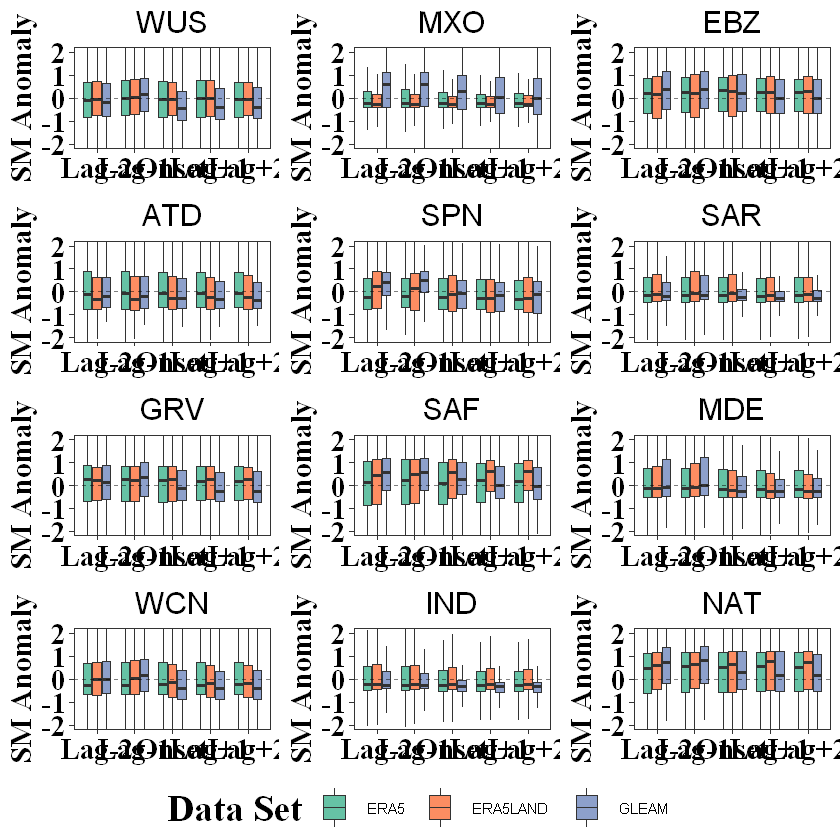

In [11]:

i=1#sm
p1=fun(i,1)
p2=fun(i,2)
p3=fun(i,3)
p4=fun(i,4)
p5=fun(i,5)
p6=fun(i,6)
p7=fun(i,7)
p8=fun(i,8)
p9=fun(i,9)
p10=fun(i,10)
p11=fun(i,11)
p12=fun(i,12)

pic_name=paste0("H:\\NO.1 flash drought\\5.小论文-骤旱\\论文大修12.2\\picture\\region\\")
 #pdf(paste0(pic_name,var[i],"_分区.pdf"),width =16, height = 12)
 ggpubr::ggarrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,ncol = 3, nrow =4,common.legend = T,legend = "bottom") 
 #dev.off()

#效果不是很好


Warning message:
"Removed 1868 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1868 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 106 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2274 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 348 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 258 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2841 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1419 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 989 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 3489 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 238 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1009 rows containing non-finite values (stat_boxplot)."
Warning message:
"Rem

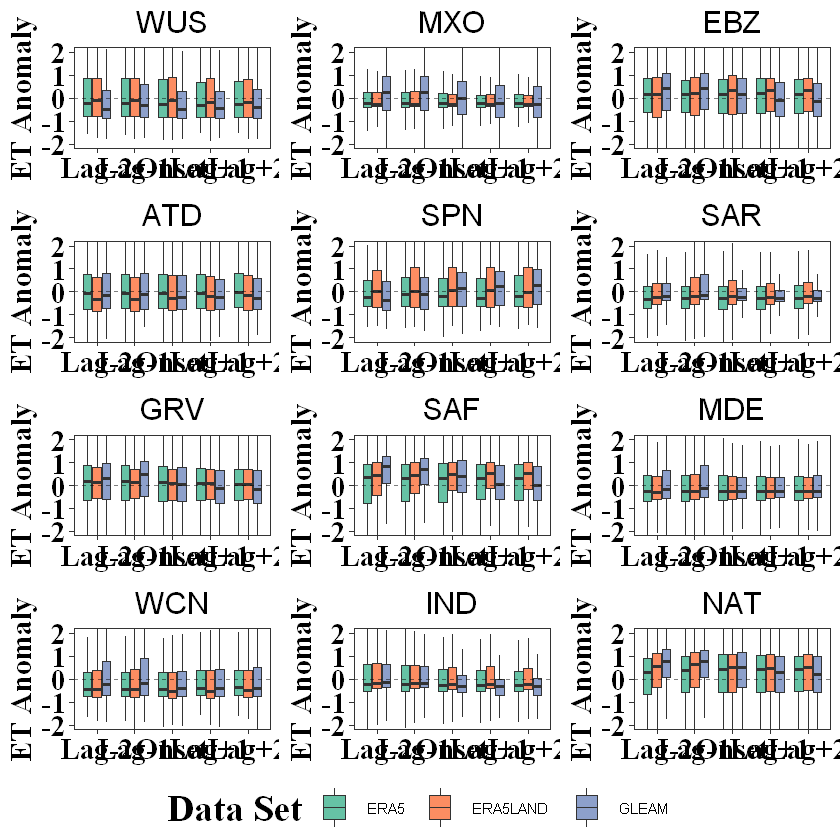

In [12]:
i=2#et
p1=fun(i,1)
p2=fun(i,2)
p3=fun(i,3)
p4=fun(i,4)
p5=fun(i,5)
p6=fun(i,6)
p7=fun(i,7)
p8=fun(i,8)
p9=fun(i,9)
p10=fun(i,10)
p11=fun(i,11)
p12=fun(i,12)

pic_name=paste0("H:\\NO.1 flash drought\\5.小论文-骤旱\\论文大修12.2\\picture\\region\\")
 #pdf(paste0(pic_name,var[i],"_分区.pdf"),width =16, height = 12)
 ggpubr::ggarrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,ncol = 3, nrow =4,common.legend = T,legend = "bottom") 
 #dev.off()

In [13]:
i=3#t
p1=fun(i,1)
p2=fun(i,2)
p3=fun(i,3)
p4=fun(i,4)
p5=fun(i,5)
p6=fun(i,6)
p7=fun(i,7)
p8=fun(i,8)
p9=fun(i,9)
p10=fun(i,10)
p11=fun(i,11)
p12=fun(i,12)

pic_name=paste0("H:\\NO.1 flash drought\\5.小论文-骤旱\\论文大修12.2\\picture\\region\\")
 pdf(paste0(pic_name,var[i],"_分区.pdf"),width =16, height = 12)
 ggpubr::ggarrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,ncol = 3, nrow =4,common.legend = T,legend = "bottom") 
 dev.off()

Warning message:
"Removed 1868 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1868 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 106 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2274 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 348 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 258 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 2841 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1419 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 989 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 3489 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 238 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1009 rows containing non-finite values (stat_boxplot)."
Warning message:
"Rem

png 
  2

In [14]:
i=4#t
p1=fun(i,1)
p2=fun(i,2)
p3=fun(i,3)
p4=fun(i,4)
p5=fun(i,5)
p6=fun(i,6)
p7=fun(i,7)
p8=fun(i,8)
p9=fun(i,9)
p10=fun(i,10)
p11=fun(i,11)
p12=fun(i,12)

pic_name=paste0("H:\\NO.1 flash drought\\5.小论文-骤旱\\论文大修12.2\\picture\\region\\")
 pdf(paste0(pic_name,var[i],"_分区.pdf"),width =16, height = 12)
 ggpubr::ggarrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,ncol = 3, nrow =4,common.legend = T,legend = "bottom") 
 dev.off()

png 
  2

In [15]:
i=5#t
p1=fun(i,1)
p2=fun(i,2)
p3=fun(i,3)
p4=fun(i,4)
p5=fun(i,5)
p6=fun(i,6)
p7=fun(i,7)
p8=fun(i,8)
p9=fun(i,9)
p10=fun(i,10)
p11=fun(i,11)
p12=fun(i,12)

pic_name=paste0("H:\\NO.1 flash drought\\5.小论文-骤旱\\论文大修12.2\\picture\\region\\")
 pdf(paste0(pic_name,var[i],"_分区.pdf"),width =16, height = 12)
 ggpubr::ggarrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,ncol = 3, nrow =4,common.legend = T,legend = "bottom") 
 dev.off()

Warning message:
"Removed 45 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 242 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 9173 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 30 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 1384 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 6658 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 67 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 64 rows containing non-finite values (stat_boxplot)."


png 
  2